In [1]:
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from Bio import SeqIO
import numpy as np
from proemb.alphabets import get_alphabet
import matplotlib.pyplot as plt
import pandas as pd

import torch
import biotite.structure.io as bsio
import tqdm 

from IPython.display import display
display.max_columns = None  # Display all columns
display.max_rows = 10000  # Display all rows

import seaborn as sns
from proemb.utils import surface_util

from Bio import BiopythonWarning
import warnings

# Suppress specific warning
warnings.simplefilter('ignore', BiopythonWarning)

from Bio.PDB import PDBParser, Selection
from Bio.PDB import PDBIO
from matplotlib.lines import Line2D

import jax.numpy as jnp

#import esm
import torch.nn as nn

import os

/Users/ioan/miniconda3/envs/prose-cpu/lib/python3.10/site-packages/Bio/pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


# Reading fasta sequences and encode-decode using our alphabets

In [28]:
folder = "data/CASP14-targets"
root = f"/scratch/ii1g17/protein-embeddings/{folder}" if 'SLURM_JOB_NAME' in os.environ else f"../../data/scratch/{folder}"

select = "first"
version = 0
esm_version_path = f"esmfold_v{version}"
pred_struct_path = f"esm-predictions/{esm_version_path}/select_cluster_{select}"

columns = ['ids', 'alphabet_name', 'select', 'run_number', 'seq'] if select == "all_possible_fixed" else ['ids', 'alphabet_name', 'select', 'seq']

alph_names = ["uniprot21", "uniprot21_reduced_2", "hsdm17",  "mmseqs2","wass_275_level_1_30bins","sdm12", "gbmr7",  "wwmj",  "gbmr4"]

alph_names_plot = ["UNIPROT20", "UNIPROT18", "HSDM17", "MMSEQS12", "WASS14", "SDM12", "GBMR7", "WWMJ5", "GBMR4"]
fasta_dict = SeqIO.to_dict(SeqIO.parse(f'{root}/seq.fasta', "fasta"), lambda rec: rec.id)

alph_to_plot_name = dict(zip(alph_names, alph_names_plot))
pal = sns.color_palette("colorblind")
pal = pal[0:-2] + [pal[-1]]
color_mapping = {k:v for k,v in zip(alph_names, pal)}

(array([34.,  9.,  4.,  2.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([  74. ,  284.6,  495.2,  705.8,  916.4, 1127. , 1337.6, 1548.2,
        1758.8, 1969.4, 2180. ]),
 <BarContainer object of 10 artists>)

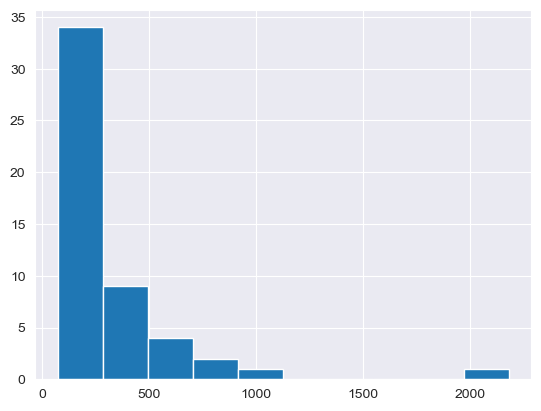

In [9]:
with open(f'{root}/esm-test-set.txt', 'r') as file:
    ids_list = [id.strip() for id in file.read().replace('\n', '').split(',')]

lenghts = []
for id in ids_list:
    lenghts.append(len(fasta_dict[id].seq))
len([l for l in lenghts if l < 500])
plt.hist(lenghts)

In [10]:
modified_seqs = {}
for seq_id in tqdm.tqdm(ids_list, total=len(ids_list)):
    seq = str(fasta_dict[seq_id].seq)
    for name in alph_names:
        alph = get_alphabet(name)
        
        if select == "all_possible_fixed":
            possible_seqs = alph.decode_reduced(alph.encode(seq.encode()), select=select)
            for i,modified_seq in enumerate(possible_seqs):
                key = f'{seq_id}.{name}.{select}.{i}'
                modified_seqs[key] = modified_seq.decode("utf-8")
        else:
            key = f'{seq_id}.{name}.{select}'
            modified_seqs[key] = alph.decode_reduced(alph.encode(seq.encode()), select=select).decode("utf-8")

df = pd.DataFrame([key.split('.') + [value] for key, value in modified_seqs.items()], columns=columns)
df.to_csv(f"{root}/alphabet_encodings_select_cluster={select}.csv")

100%|██████████| 51/51 [00:00<00:00, 221.61it/s]


In [29]:
df = pd.read_csv(f"{root}/alphabet_encodings_select_cluster={select}.csv")
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ids,alphabet_name,select,seq,pLDDT,LDDT
0,0,0,1,1,T1024,uniprot21,first,MKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITG...,94.079695,79.821074
1,1,1,3,3,T1024,uniprot21_reduced_2,first,MKEFWNHDKNHQHRHGIVFHGAFSYGTVFSSMTIYYNQYHGSAITG...,80.404882,67.575496
2,2,2,5,5,T1024,sdm12,first,LKKYWNLDKNLTLKLGLLYLGAYTYGTLYTTLTLYYNTYLGTALTG...,88.405821,67.061913
3,3,3,7,7,T1024,gbmr4,first,YAAYYAYAAAYAYAYGYYYYGAYAYGAYYAAYAYYYAAYYGAAYAG...,37.073697,28.559595
4,4,4,9,9,T1024,gbmr7,first,AAAAADADADAAAAAGAAAAGAASAGTAASSATAAADAAAGSAATG...,42.432346,28.677931
...,...,...,...,...,...,...,...,...,...,...
454,454,454,909,909,T1099,gbmr7,first,ADADASAAAADAADAPDDAAPAADDAAADAADAAAPAAASDSAAAC...,51.856821,44.774851
455,455,455,911,911,T1099,hsdm17,first,MDLNASRALANLYDLPDDFFPKLDDLLRDAKDALKPYWKSDSLKKH...,53.126242,45.631549
456,456,456,913,913,T1099,wass_275_level_1_30bins,first,WDDNASRALANAYDLPDDFFPKDDDLARDAKDALRPYWKSDSDKKS...,43.315601,37.234494
457,457,457,915,915,T1099,mmseqs2,first,LNINAAKALANIFNLPNNFFPKINNLIKNAKNALEPFWKANAIKKH...,39.170143,43.960634


# ESMFold predictions

In [4]:
"""
Taken from AlphaFold2 implementation
"""
def lddt(predicted_points,
         true_points,
         true_points_mask,
         cutoff=15.,
         per_residue=False):
  """Measure (approximate) lDDT for a batch of coordinates.

  lDDT reference:
  Mariani, V., Biasini, M., Barbato, A. & Schwede, T. lDDT: A local
  superposition-free score for comparing protein structures and models using
  distance difference tests. Bioinformatics 29, 2722–2728 (2013).

  lDDT is a measure of the difference between the true distance matrix and the
  distance matrix of the predicted points.  The difference is computed only on
  points closer than cutoff *in the true structure*.

  This function does not compute the exact lDDT value that the original paper
  describes because it does not include terms for physical feasibility
  (e.g. bond length violations). Therefore this is only an approximate
  lDDT score.

  Args:
    predicted_points: (batch, length, 3) array of predicted 3D points
    true_points: (batch, length, 3) array of true 3D points
    true_points_mask: (batch, length, 1) binary-valued float array.  This mask
      should be 1 for points that exist in the true points.
    cutoff: Maximum distance for a pair of points to be included
    per_residue: If true, return score for each residue.  Note that the overall
      lDDT is not exactly the mean of the per_residue lDDT's because some
      residues have more contacts than others.

  Returns:
    An (approximate, see above) lDDT score in the range 0-1.
  """

  assert len(predicted_points.shape) == 3
  assert predicted_points.shape[-1] == 3
  assert true_points_mask.shape[-1] == 1
  assert len(true_points_mask.shape) == 3

  # Compute true and predicted distance matrices.
  dmat_true = jnp.sqrt(1e-10 + jnp.sum(
      (true_points[:, :, None] - true_points[:, None, :])**2, axis=-1))

  dmat_predicted = jnp.sqrt(1e-10 + jnp.sum(
      (predicted_points[:, :, None] -
       predicted_points[:, None, :])**2, axis=-1))

  dists_to_score = (
      (dmat_true < cutoff).astype(jnp.float32) * true_points_mask *
      jnp.transpose(true_points_mask, [0, 2, 1]) *
      (1. - jnp.eye(dmat_true.shape[1]))  # Exclude self-interaction.
  )

  # Shift unscored distances to be far away.
  dist_l1 = jnp.abs(dmat_true - dmat_predicted)

  # True lDDT uses a number of fixed bins.
  # We ignore the physical plausibility correction to lDDT, though.
  score = 0.25 * ((dist_l1 < 0.5).astype(jnp.float32) +
                  (dist_l1 < 1.0).astype(jnp.float32) +
                  (dist_l1 < 2.0).astype(jnp.float32) +
                  (dist_l1 < 4.0).astype(jnp.float32))

  # Normalize over the appropriate axes.
  reduce_axes = (-1,) if per_residue else (-2, -1)
  norm = 1. / (1e-10 + jnp.sum(dists_to_score, axis=reduce_axes))
  score = norm * (1e-10 + jnp.sum(dists_to_score * score, axis=reduce_axes))

  return score

def predict_struct(model, seq, name, chunk):
    
    # Optionally, uncomment to set a chunk size for axial attention. This can help reduce memory.
    # Lower sizes will have lower memory requirements at the cost of increased speed.
    model.set_chunk_size(chunk)

    with torch.no_grad():
        output = model.infer_pdb(seq)

    with open(f"{name}.pdb", "w") as f:
        f.write(output)
    
def get_mean_pLDDT(name):
    
    struct = bsio.load_structure(name,  extra_fields=["b_factor"])
    return struct.b_factor.mean()

def get_pLDDT_alpha_carbon(name):
    
    parser = PDBParser()
    return np.array([res["CA"].get_bfactor() for res in parser.get_structure("a", name)[0].get_residues()])

def load_model(root, version=0):
    
    if version == 0:
        # load from local pytorch hub
        torch.hub.set_dir(root)
        model = esm.pretrained.esmfold_v0()
    else:
        # this is the v1 but is loaded from pickle
        model = torch.load(f"{root}esmfold.model")
    model.eval().cuda()
    
    return model

In [5]:
model = load_model(root, version)
chunk = 1024
output_log = f'{root}esm-predictions/{esm_version_path}/progress.log'

for row in tqdm.tqdm(df[columns].values):
    
    if select == "all_possible_fixed":
        prot_id, alphabet_name, select, i, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}_{i}'
    else:
        prot_id, alphabet_name, select, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}'
    
    output_file = f'{root}esm-predictions/{esm_version_path}/{name}'
    
    #ignore the seq with size 2k
    if len(seq) > 1000:
        continue
    
    if len(seq) > 500:
        chunk = 512
    
    if os.path.exists(f'{output_file}.pdb'):
        print(f"File '{output_file}' already exists")
        continue
    
    predict_struct(model, seq, name=output_file, chunk=chunk)
    print("Processed ", name)
    
    with open(output_log, 'a') as log_file:
        log_file.write(f"Processed: {name}\n")
    
    chunk=1024


KeyboardInterrupt



## Crop and save structures to match target domain range

In [69]:
# target CAPS14 is only a part of the input seq
# we crop the predicted structures so we can nicely visualise the superimposed structures
parser = PDBParser()
io = PDBIO()

for row in tqdm.tqdm(df[columns].values):
    
    if select == "all_possible_fixed":
        prot_id, alphabet_name, select, i, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}_{i}'
    else:
        prot_id, alphabet_name, select, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}'
    
    if prot_id == "T1044":
        continue
    
    if os.path.exists(f"{root}/{pred_struct_path}/cropped-structures/{name}.pdb"):
        continue

    target_struct = parser.get_structure("a", f"{root}/structures/{prot_id}.pdb")[0]      
    residues_ids = [res.id for res in target_struct.get_residues()]
    range_crop = (residues_ids[0][1], residues_ids[-1][1])
    
    pred_struct = parser.get_structure("a", f"{root}/{pred_struct_path}/{name}.pdb")[0]
    
    for chain in Selection.unfold_entities(pred_struct, 'C') :
        for residue in list(chain.get_residues()):
            residue_position = residue.id[1]
            if residue_position < range_crop[0] or residue_position > range_crop[1]:
                chain.detach_child(residue.id)
                
    io.set_structure(pred_struct)
    io.save(f"{root}/{pred_struct_path}/cropped-structures/{name}.pdb")

  0%|          | 0/459 [00:01<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '../../data/scratch/data/CASP14-targets/esm-predictions/esmfold_v0/select_cluster_random/cropped-structures/T1024_uniprot21_random.pdb'

### Plot pLDDT for CASP14

In [ ]:
pLDDTs = []
LDDTs = []
parser = PDBParser()

for row in tqdm.tqdm(df[columns].values):
    
    if select == "all_possible_fixed":
        prot_id, alphabet_name, select, i, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}_{i}'
    else:
        prot_id, alphabet_name, select, seq = row
        name = f'{prot_id}_{alphabet_name}_{select}'

    #ignore the seq with size 2k
    if prot_id == "T1044":
        pLDDTs.append(np.nan)
        LDDTs.append(np.nan)
        continue
        
    pred_struct_name = f"{root}/{pred_struct_path}/{name}.pdb"
    
    plDDT = get_mean_pLDDT(pred_struct_name)
    pLDDTs.append(plDDT)
    
    target_struct = parser.get_structure("a", f"{root}/structures/{prot_id}.pdb")[0]
    target_coord = np.array([res["CA"].get_coord() for res in target_struct.get_residues()])
    target_coord = target_coord[None, :, :]
    # we want to look at the entire target
    true_points = np.ones((1,target_coord.shape[1], 1))
    
    seq_from_struct = surface_util.get_seq_from_struct(target_struct)
    mask = surface_util.get_alignment_mask(fasta_dict[prot_id].seq, ''.join(seq_from_struct))

    pred_struct = parser.get_structure("a", pred_struct_name)[0]
    pred_coord = np.array([res["CA"].get_coord() for res in pred_struct.get_residues()])
    
    # select only the predicted structure for which we have target data
    pred_coord = pred_coord[mask]
    pred_coord = pred_coord[None, :, :]

    LDDTs.append(np.array(lddt(pred_coord, target_coord, true_points))[0] * 100)
    
df['pLDDT'] = pLDDTs
df['LDDT'] = LDDTs
df.to_csv(f"{root}/alphabet_encodings_select_cluster={select}.csv")

In [73]:
df_random = df

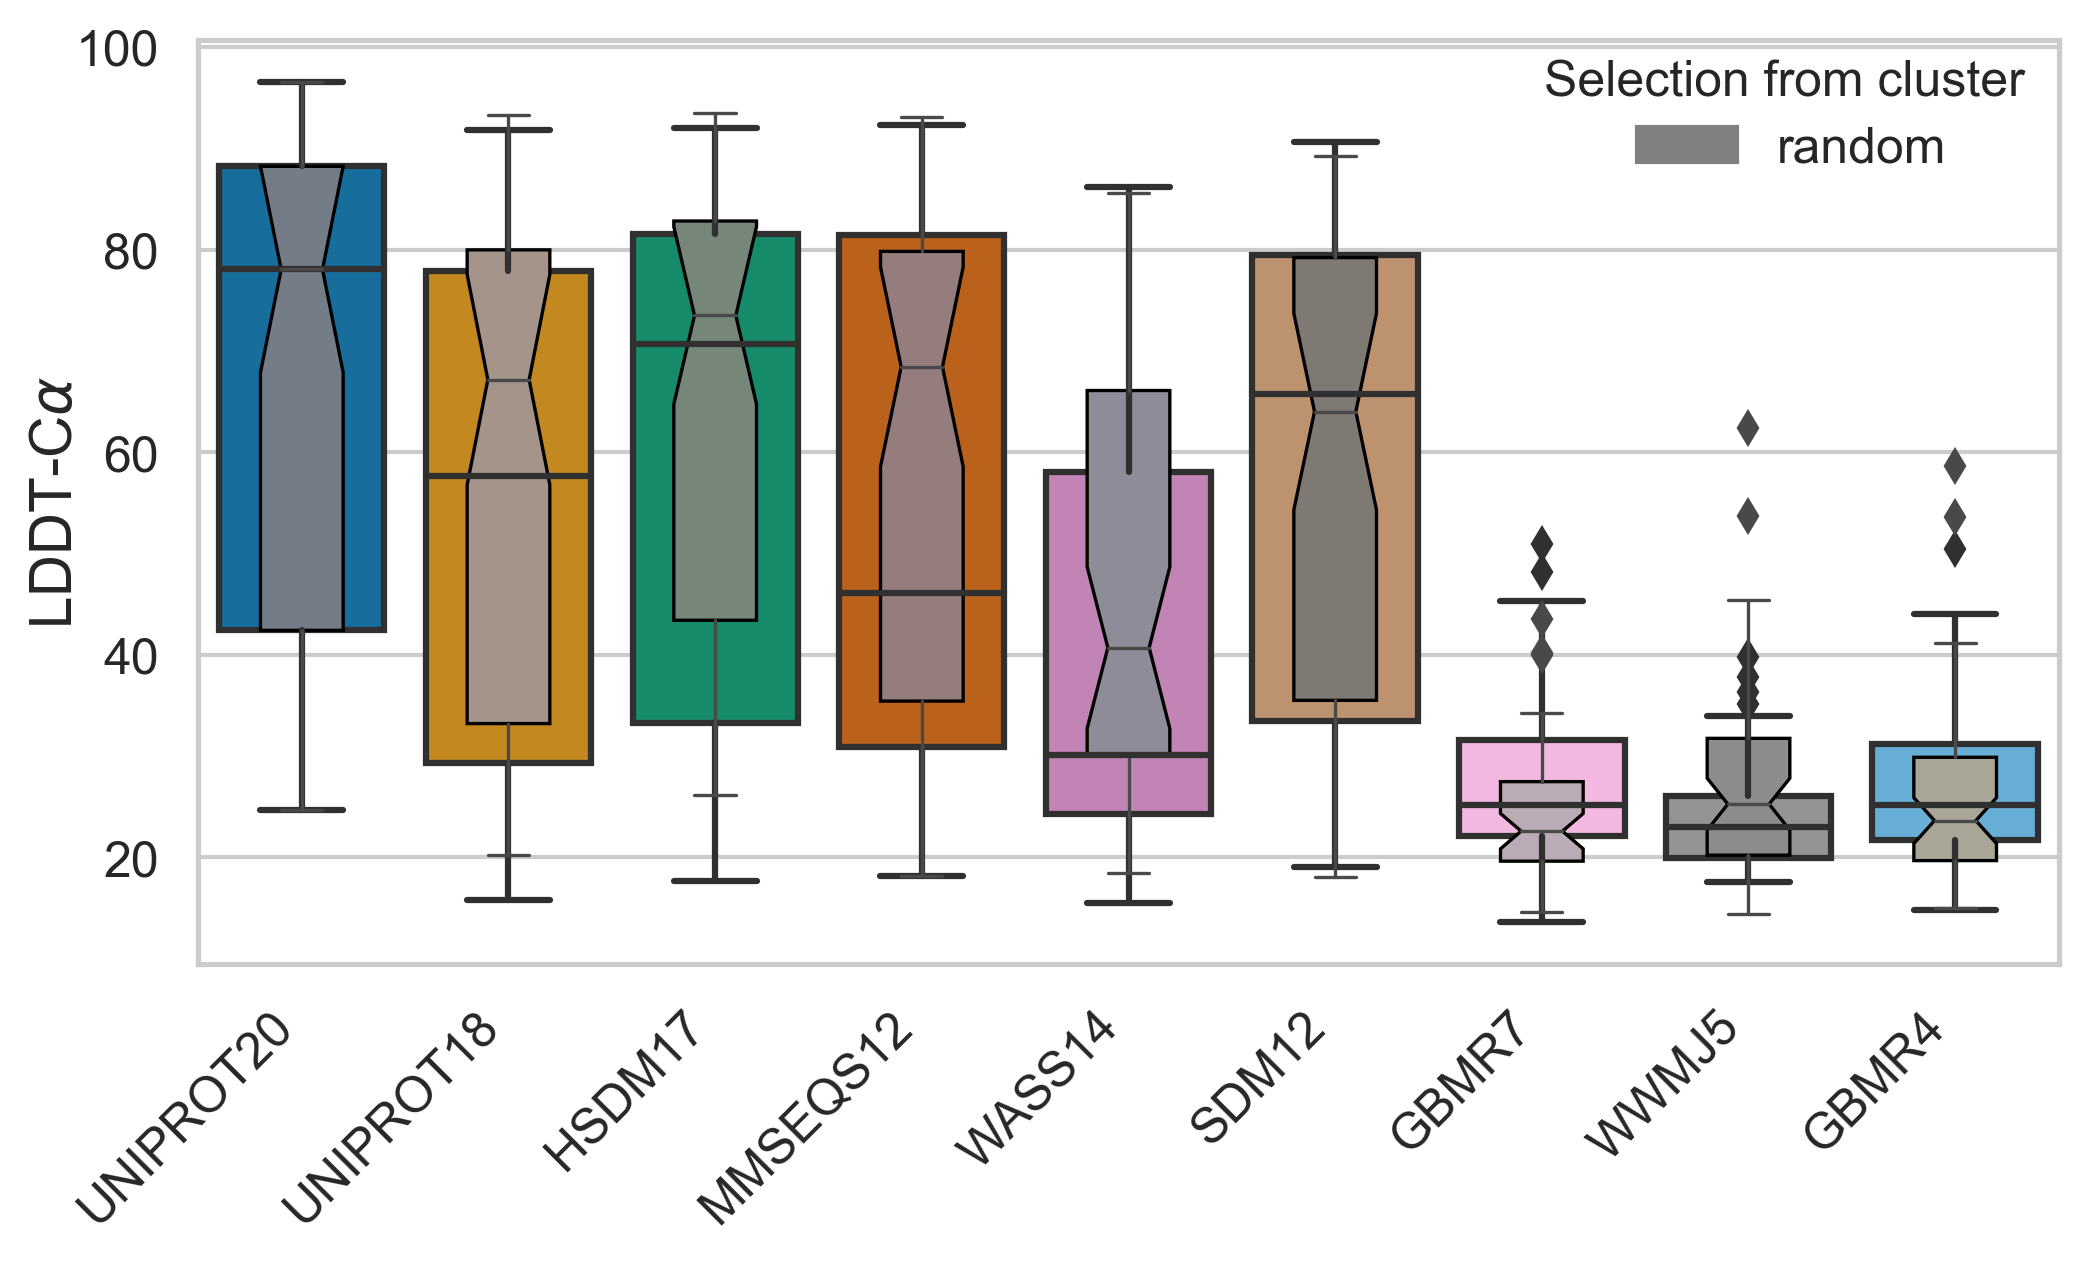

In [81]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.boxplot(x='alphabet_name', y="LDDT", data=df_first ,showfliers=True, ax=ax,  width=0.8, order=alph_names, palette=pal)
sns.boxplot(x='alphabet_name', y="LDDT", data=df_random ,showfliers=True, ax=ax, saturation=0.2, width=0.4,
            order=alph_names, linewidth=0.8, boxprops={'edgecolor':'black'},  notch=True)

ax.set_xticklabels(alph_names_plot, rotation=45, ha='right', fontsize=12)
plt.yticks( fontsize=12);
plt.ylabel(r'LDDT-C$\alpha$', fontsize=14, labelpad=-2)
plt.xlabel("")

# Create a custom legend based on the bar labels and colors
legend_handles = [plt.Rectangle((0,0),1,1, color='grey',  alpha=1)]
ax.legend(legend_handles, ["random"], ncol=1, loc="upper right", bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=12,labelspacing=0.4,frameon=False, title="Selection from cluster ", title_fontsize=12)

plt.savefig(f'results/esm_v{version}-lddt-CASP14-alphabets-select-aa-from-cluster={select}.pdf', bbox_inches='tight', dpi=300)

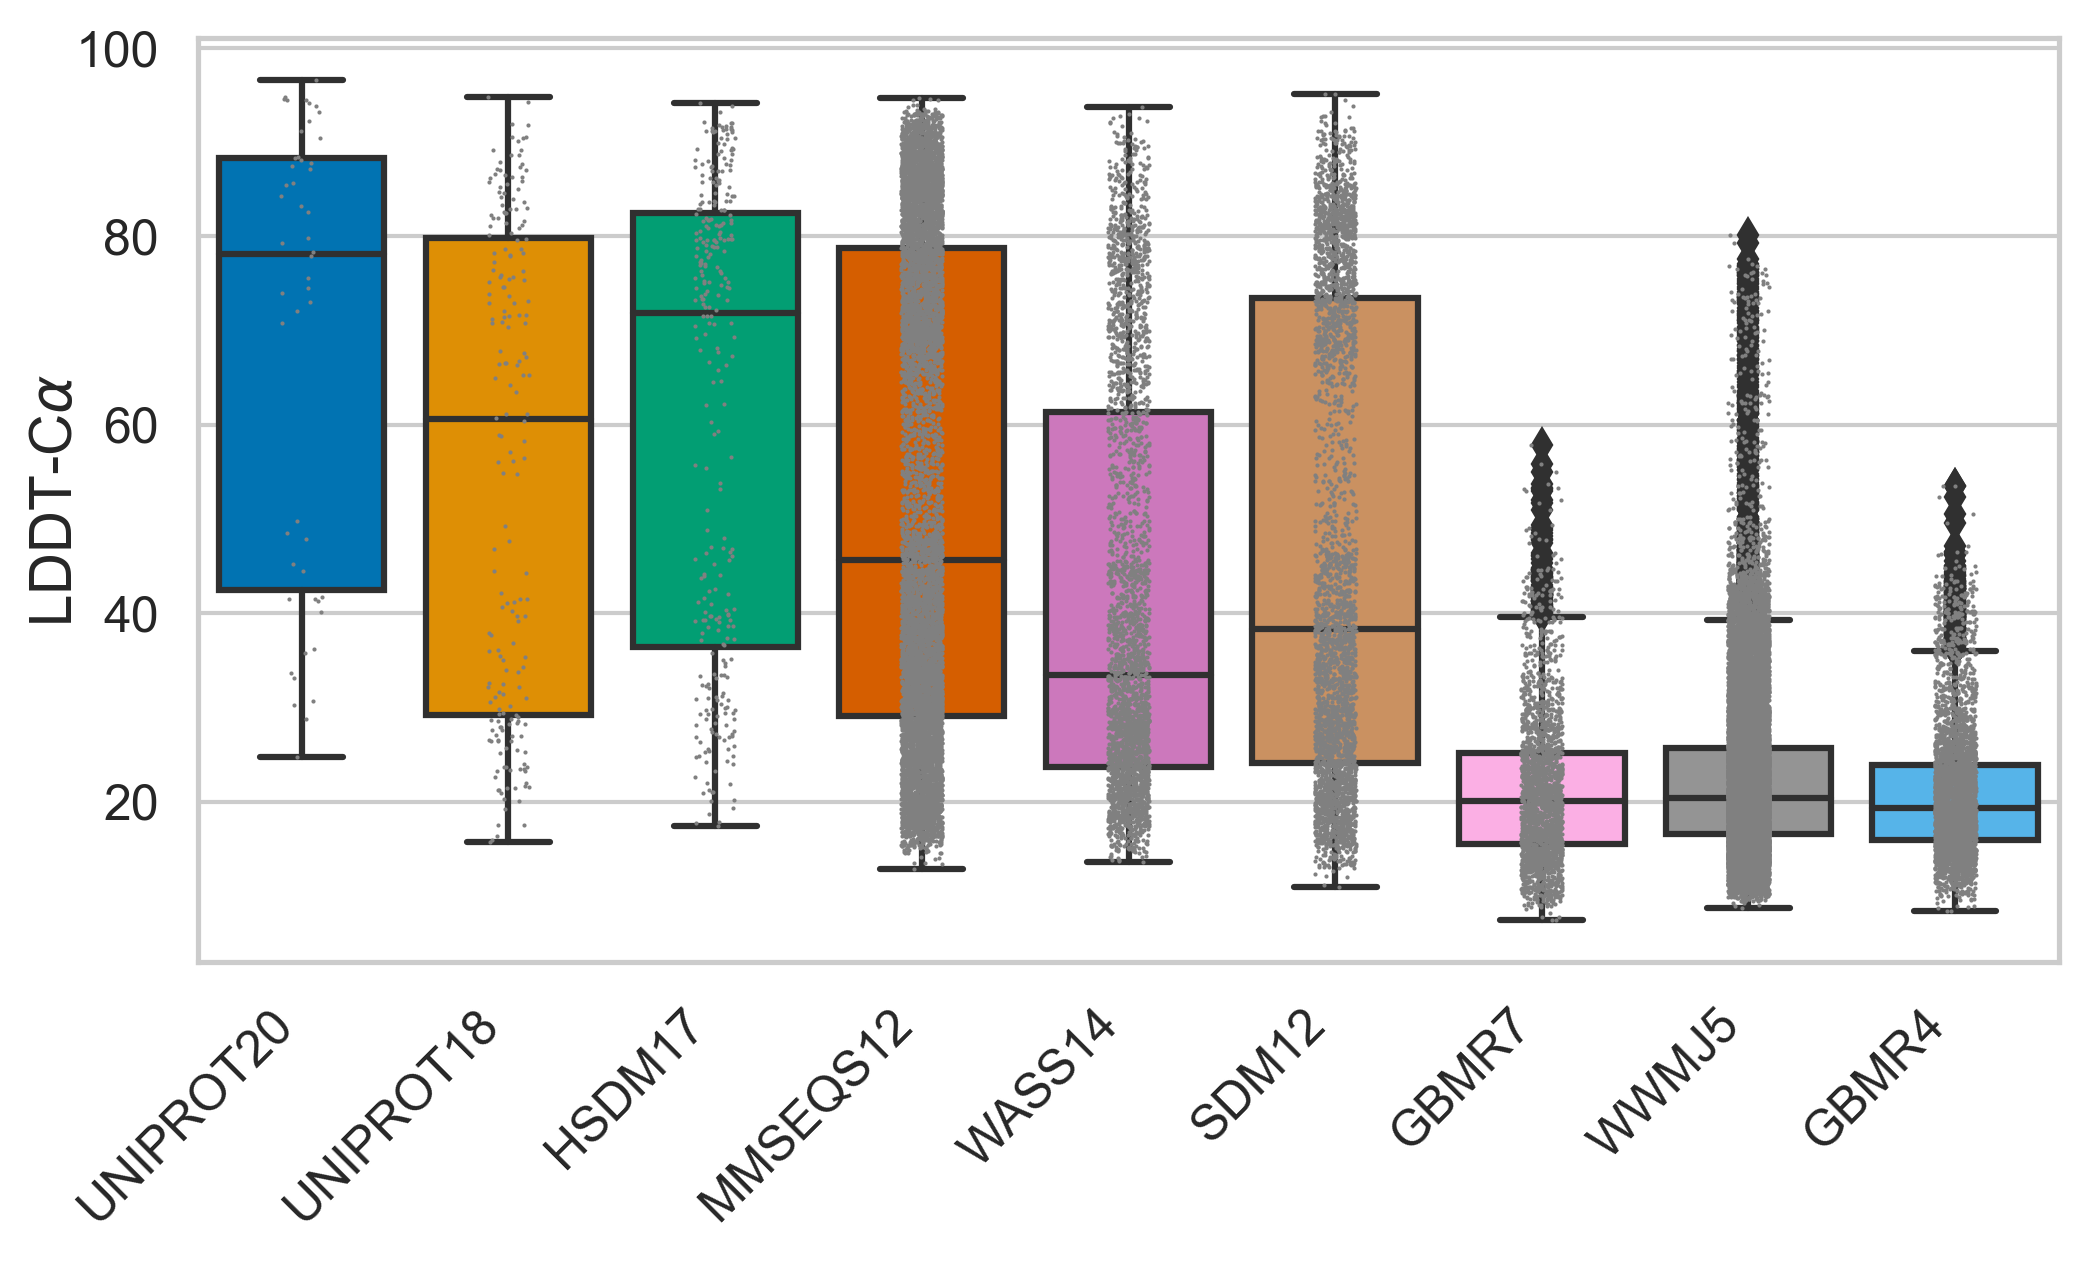

In [20]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.boxplot(x='alphabet_name', y="LDDT", data=df ,showfliers=True, ax=ax, order=alph_names, palette=pal, saturation=1)
sns.stripplot(x='alphabet_name', y="LDDT", data=df , color="grey", size=1, order=alph_names, alpha=1)

ax.set_xticklabels(alph_names_plot, rotation=45, ha='right', fontsize=12)
plt.yticks( fontsize=12);
plt.ylabel(r'LDDT-C$\alpha$', fontsize=14, labelpad=-2)
plt.xlabel("")

plt.savefig(f'results/esm_v{version}-lddt-CASP14-alphabets-select-aa-from-cluster={select}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/esm_v{version}-lddt-CASP14-alphabets-select-aa-from-cluster={select}.eps', bbox_inches='tight', dpi=300)

In [ ]:
metric = 'LDDT'
label = R'LDDT-C$\alpha$'

for (name, plot_alph_name) in zip(alph_names, alph_names_plot):
      
    if name == 'uniprot21':
        continue
    fig, ax = plt.subplots(figsize=(6, 4), dpi=80)
    
    # Scatter plot for 'uniprot21' and 'wwmj' with 'select' as 'first'
    if select != 'all_possible_fixed':
        plt.scatter(df[df['alphabet_name'] == 'uniprot21'][metric], df[df['alphabet_name'] == name][metric])
        
    else:
        for prot_id in set(df['ids']):
            # replicate the uniprot pred number of times to match the one of the alphabet
            alphabet_examples = df[(df['alphabet_name'] == name) & (df['ids'] == prot_id)]
            uniprot_examples = df[(df['ids'] == prot_id) & (df['alphabet_name'] == 'uniprot21')]
            uniprot_examples =  pd.DataFrame(np.repeat(uniprot_examples.values, len(alphabet_examples), axis=0))
            uniprot_examples.columns = alphabet_examples.columns
            
            plt.scatter(uniprot_examples[metric], alphabet_examples[metric])
            
    plt.plot([0, 100], [0, 100], color='grey', linestyle='--')
    
    plt.xlabel(f'{label} for UNIPROT20', fontsize=14)
    plt.ylabel(f'{label} for {plot_alph_name}', fontsize=14)
    
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.yticks( fontsize=12)
    plt.xticks( fontsize=12)
    plt.legend()
    
    plt.savefig(f'results/uniprot20vs{plot_alph_name}-lddt-select={select}-esm_v{version}.pdf', bbox_inches='tight', dpi=300)
    plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


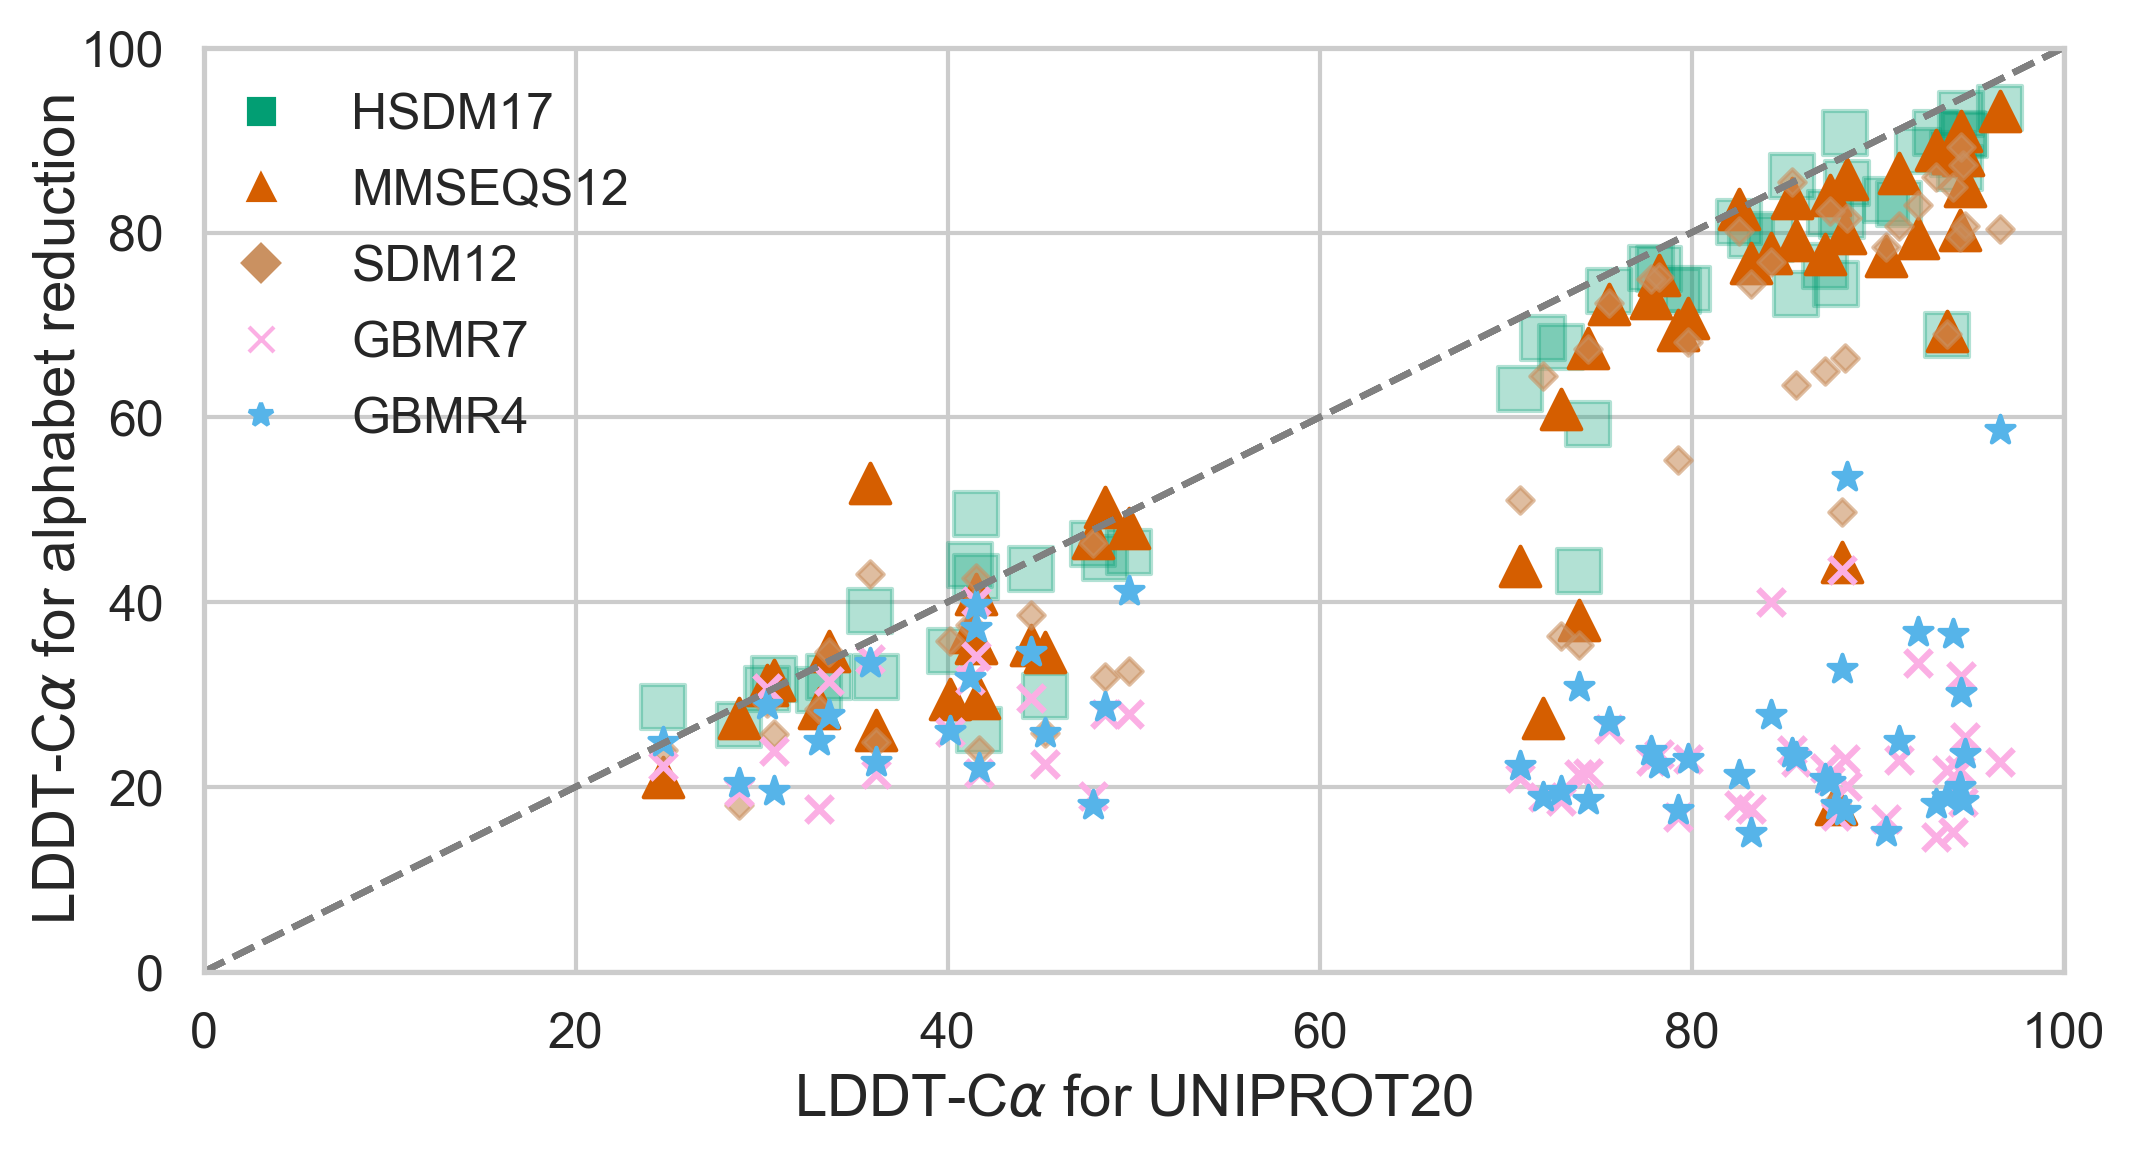

In [76]:
metric = 'LDDT'
label = R'LDDT-C$\alpha$'

fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

markers = dict(zip(alph_names_plot[1:], ['o', 's', '^', 'v', 'D', 'x', '+', '*']))
sizes = dict(zip(alph_names_plot[1:], [10, 110, 90, 40, 20, 40, 50, 50]))
alphas = dict(zip(alph_names_plot[1:], [1, 0.3, 1, 0.4, 0.6, 1,1,1]))
colors = {k:v for k,v in zip(alph_names_plot, pal)}

elements = []
for (name, plot_alph_name) in zip(alph_names, alph_names_plot):
    
    if plot_alph_name not in ['HSDM17', 'MMSEQS12', 'GBMR7', 'GBMR4', 'SDM12']:
        continue
    
    # Scatter plot for 'uniprot21' and 'wwmj' with 'select' as 'first'
    plt.scatter(df[df['alphabet_name'] == 'uniprot21'][metric], df[df['alphabet_name'] == name][metric],
                marker=markers[plot_alph_name], s=sizes[plot_alph_name], alpha=alphas[plot_alph_name], color = colors[plot_alph_name])
    
    plt.plot([0, 100], [0, 100], color='grey', linestyle='--')
    plt.xlabel(f'{label} for UNIPROT20', fontsize=14)
    plt.ylabel(f'{label} for alphabet reduction', fontsize=14, labelpad=-2)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.yticks( fontsize=12)
    plt.xticks( fontsize=12)

    elements.append(Line2D([], [], marker=markers[plot_alph_name], label=plot_alph_name,linestyle='None', color=colors[plot_alph_name]))
                    
lgnd = plt.legend(handles=elements, loc='upper left', prop={'size': 12},labelspacing=0.6,frameon=False, title_fontsize=14, bbox_to_anchor=(-0.02, 1))

plt.savefig(f'results/uniprot20_vs_all-lddt-select={select}-esm_v{version}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/uniprot20_vs_all-lddt-select={select}-esm_v{version}.eps', bbox_inches='tight', dpi=300)
    # Show the plot
plt.show()


In [9]:
def calculate_LDDT_change(row):
    baseline_value = baseline_lddt.get(row['ids'])
    if baseline_value is not None:
        percentage_change = row['LDDT'] - baseline_value
        return percentage_change
    return None

baseline_lddt = df[df['alphabet_name'] == 'uniprot21'].set_index('ids')['LDDT'].to_dict()
df['percentage_change'] = df.apply(calculate_LDDT_change, axis=1)

In [10]:
filtered_df = df.dropna(subset=['percentage_change'])
filtered_df = filtered_df[filtered_df['percentage_change'] > 1]

columns = ['ids', 'alphabet_name', 'percentage_change', 'LDDT']
columns += ['run_number'] if select == "all_possible_fixed" else []
filtered_df = filtered_df[columns]

# we select the maximum percentage change for protein
if select == "all_possible_fixed":
    filtered_df = filtered_df.loc[filtered_df.groupby(['ids', 'alphabet_name'])['percentage_change'].idxmax()]

# Pivot the data to have proteins as rows and alphabet types as columns
pivot_df = filtered_df.pivot(index='ids', columns='alphabet_name', values='percentage_change')
selected_alph = [name for name in alph_names if name in pivot_df.columns]
pivot_df = pivot_df[selected_alph]

# Set up the color palette based on the number of alphabet types
num_alphabets = pivot_df.shape[1]
selected_alph_index = [a in selected_alph for i,a in enumerate(alph_names)]
filtered_pal = [b for a,b in zip(selected_alph_index, pal) if a]

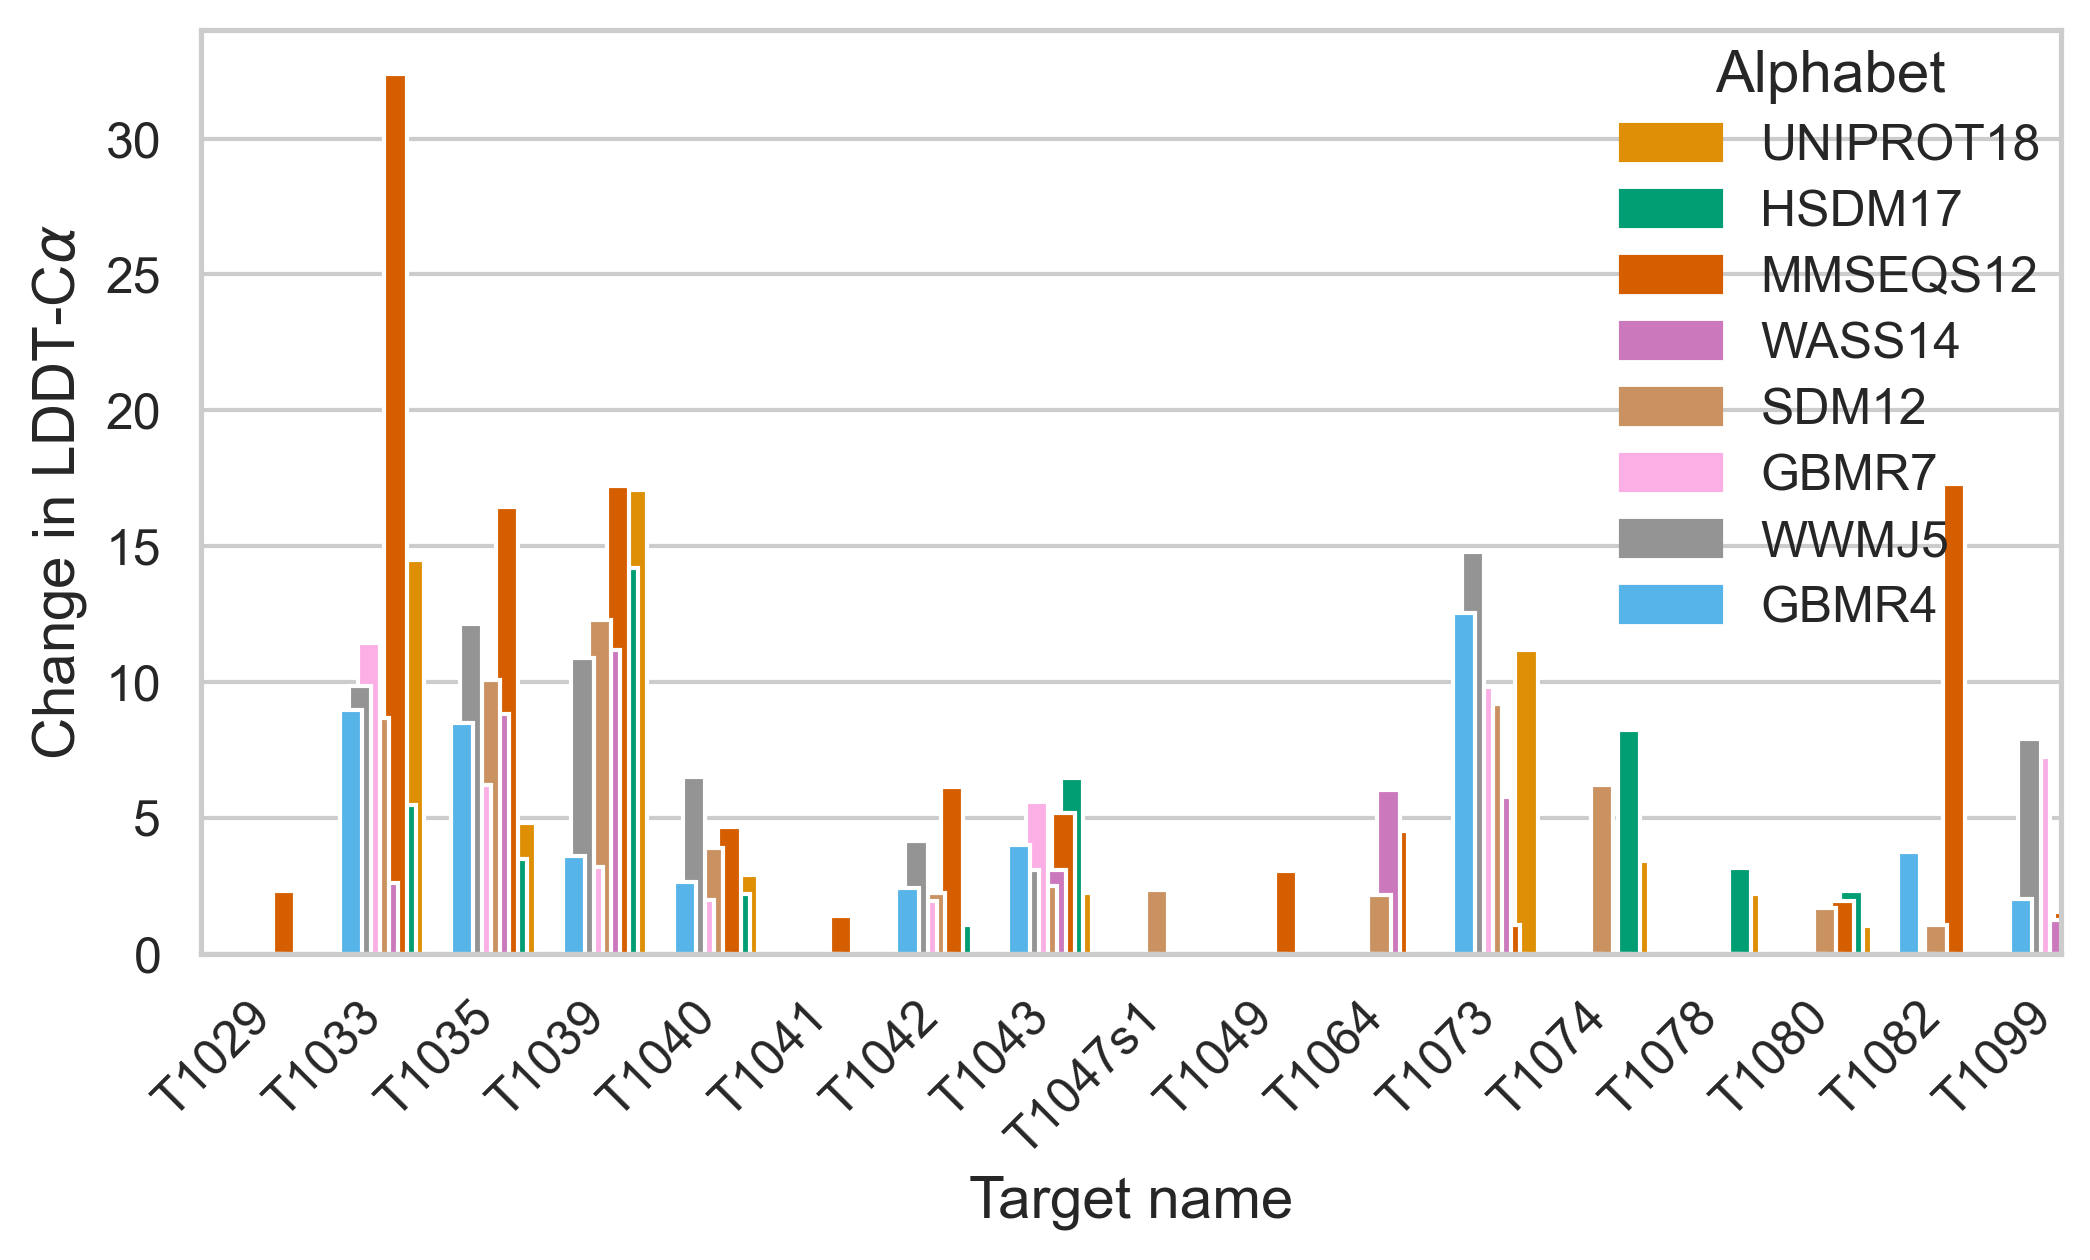

In [19]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

offset = 0
for i, alphabet_name in enumerate(selected_alph):
    pivot_df[[alphabet_name]].plot(kind='bar', ax=ax, label=alphabet_name, align='edge', width=0.2, color=color_mapping[alphabet_name], alpha=1, position=offset)
    offset +=0.40

plt.xlabel("Target name", labelpad=3, size=14)
plt.ylabel(r"Change in LDDT-C$\alpha$", size=14, labelpad=4)

plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)
plt.gca().xaxis.grid(False)

# Create a custom legend based on the bar labels and colors
legend_handles = [plt.Rectangle((0,0),1,1, color=filtered_pal[i], alpha=1) for i in range(0, len(filtered_pal))]
ax.legend(legend_handles, [alph_to_plot_name[n] for n in selected_alph], ncol=1, loc="upper right", bbox_to_anchor=(1, 1), borderaxespad=0., fontsize=12,labelspacing=0.4,frameon=False, title="Alphabet", title_fontsize=14)

plt.savefig(f'results/esm_v0-lddt-CASP14-alphabets-select-aa-from-cluster={select}-difference-to-uniprot21.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/esm_v0-lddt-CASP14-alphabets-select-aa-from-cluster={select}-difference-to-uniprot21.eps', bbox_inches='tight', dpi=300)
plt.show()

In [100]:
def get_LDDT_residue(prot_id, name):
    
    target_struct = parser.get_structure("a", f"../../data/CASP14-targets/structures/{prot_id}.pdb")[0]
    target_coord = np.array([res["CA"].get_coord() for res in target_struct.get_residues()])
    target_coord = target_coord[None, :, :]
    # we want to look at the entire target
    true_points = np.ones((1,target_coord.shape[1], 1))
    
    seq_from_struct = surface_util.get_seq_from_struct(target_struct)
    mask = surface_util.get_alignment_mask(fasta_dict[prot_id].seq, ''.join(seq_from_struct))
    
    pred_struct = parser.get_structure("a", f"{root}esm-predictions/{esm_version_path}/{name}.pdb")[0]
    pred_coord = np.array([res["CA"].get_coord() for res in pred_struct.get_residues()])
    
    # select only the predicted structure for which we have target data
    pred_coord = pred_coord[mask]
    pred_coord = pred_coord[None, :, :]
    
    return np.array(lddt(pred_coord, target_coord, true_points, per_residue=True)[0]) * 100

data_sets = [
    ("T1033", "mmseqs2"),
    ("T1035", "gbmr4"),
    ("T1039", "hsdm17")
]
lddt_uniprot, lddt_alph, plddt_uniprot, plddt_alph = [], [], [], []

for id, alph in data_sets:
    uniprot_filename = f"{id}_uniprot21_{select}"
    alph_filename = f"{id}_{alph}_{select}"
    
    lddt_uniprot.append(get_LDDT_residue(id, uniprot_filename))
    lddt_alph.append(get_LDDT_residue(id, alph_filename))
    
    plddt_uniprot.append(get_pLDDT_alpha_carbon(f"{root}esm-predictions/{esm_version_path}/{uniprot_filename}.pdb"))
    plddt_alph.append(get_pLDDT_alpha_carbon(f"{root}esm-predictions/{esm_version_path}/{alph_filename}.pdb"))


FileNotFoundError: [Errno 2] No such file or directory: '../../data/scratch/data/CASP14-targetsesm-predictions/esmfold_v0/T1033_uniprot21_first.pdb'

/var/folders/0t/xsc02g1j6z79zd6mkph9lh980000gp/T/ipykernel_2234/908178481.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(np.arange(0, 161, 20))


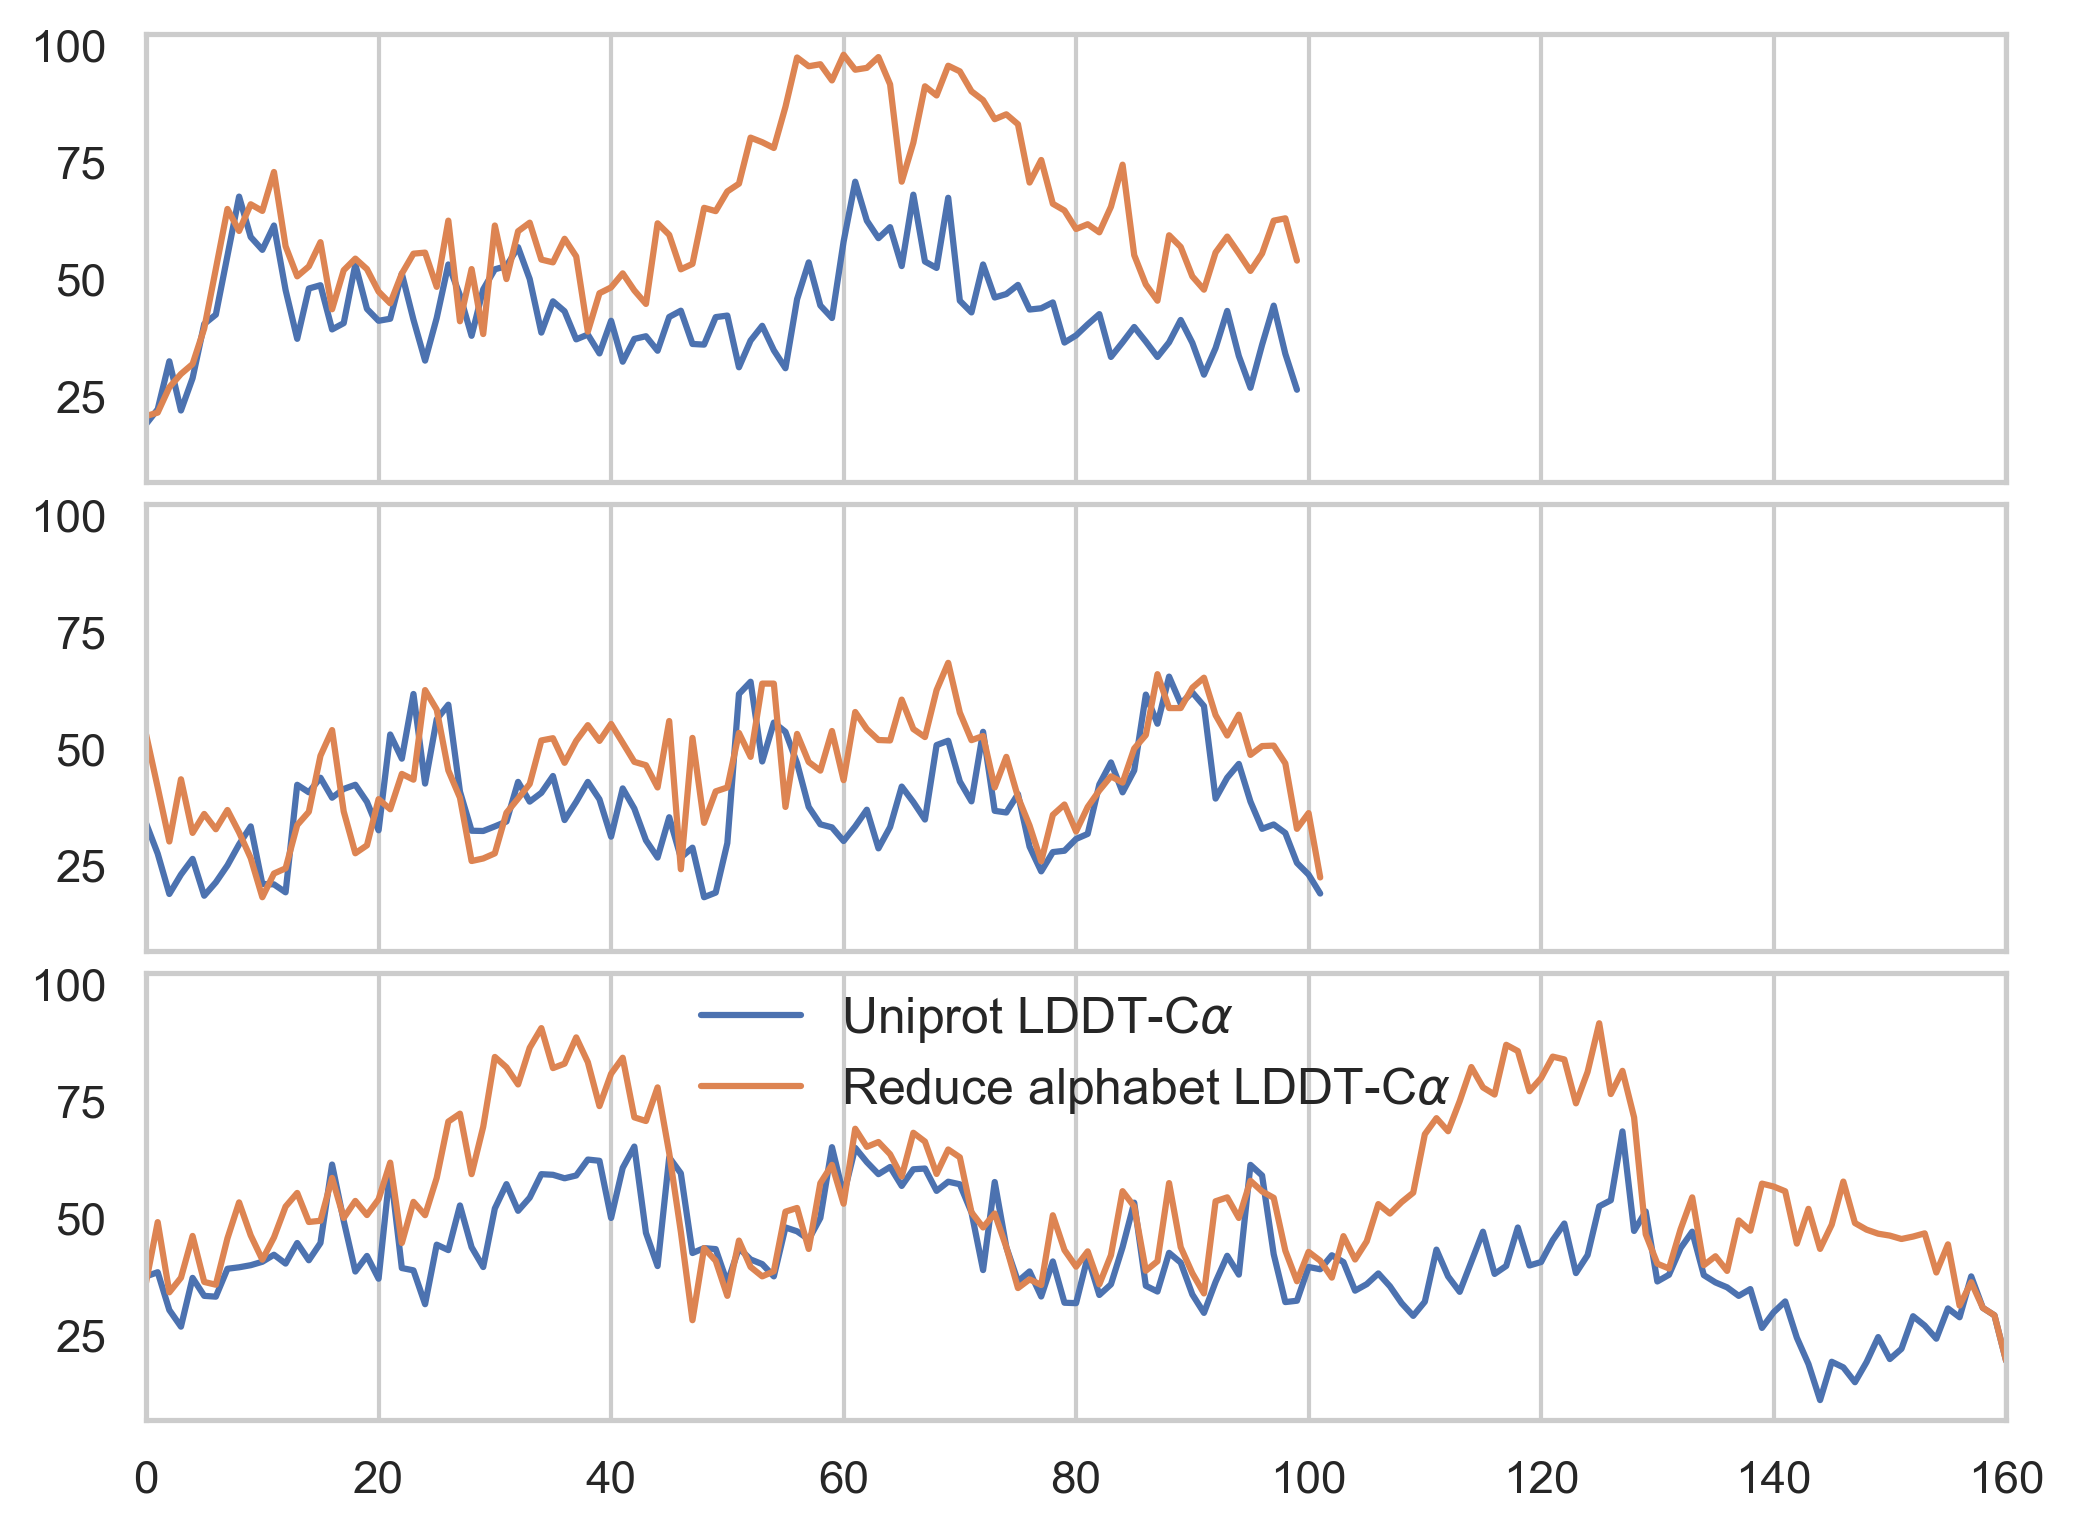

In [292]:
sns.set_theme(style="whitegrid")
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True, figsize=(8, 6), dpi=300)

axes = [ax1, ax2, ax3]

for a in axes:
    a.yaxis.grid(False)
    a.margins(x=0)

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels(np.arange(0, 161, 20))

for i, ax in enumerate(axes):
    ax.plot(lddt_uniprot[i], label=r"Uniprot LDDT-C$\alpha$")
    ax.plot(lddt_alph[i], label= r"Reduce alphabet LDDT-C$\alpha$")
    #ax.plot(plddt_uniprot[i])
    #ax.plot(plddt_alph[i])
    
    
plt.legend(borderaxespad=0., fontsize=12,labelspacing=0.4,frameon=False, title_fontsize=14)

plt.subplots_adjust(hspace=0.05)

In [545]:
seqa = "NNPLSSKLTKYYTNFKYKLLPGGKLNKGKLKDLQSTLTSLLKKTRKKNNPKYKSDSDFYKLFKKGLLKLMQLFKDLGLDSLTFKAMDLFLKQFRFDLPKNNAYKLMYQQYQGKLTNLNNLLKDLQSNKLNPYKLNPFKNYSNLLFNSLAKAKNYFLKNNNK"

seqb = "NNPISSKLTEYYTNFKYKILPGGKLNKGKLKDLQSTVTSLLEKTRKENNPKYKSDSDFYEVFEEGVVELMQVFEDLGVDSITFEAMDIFLKQFRFDLPENNAYKIMYQQYQGKLTNLNNLLKDIQSNKINPYKINPFKNYSNLIFNSLAEAENYFIENNNE"

align = pairwise2.align.globalds(seqa, seqb, blosum62, -10, -0.5)
align[0][0]

'NNPLSSKLTKYYTNFKYKLLPGGKLNKGKLKDLQSTLTSLLKKTRKKNNPKYKSDSDFYKLFKKGLLKLMQLFKDLGLDSLTFKAMDLFLKQFRFDLPKNNAYKLMYQQYQGKLTNLNNLLKDLQSNKLNPYKLNPFKNYSNLLFNSLAKAKNYFLKNNNK'

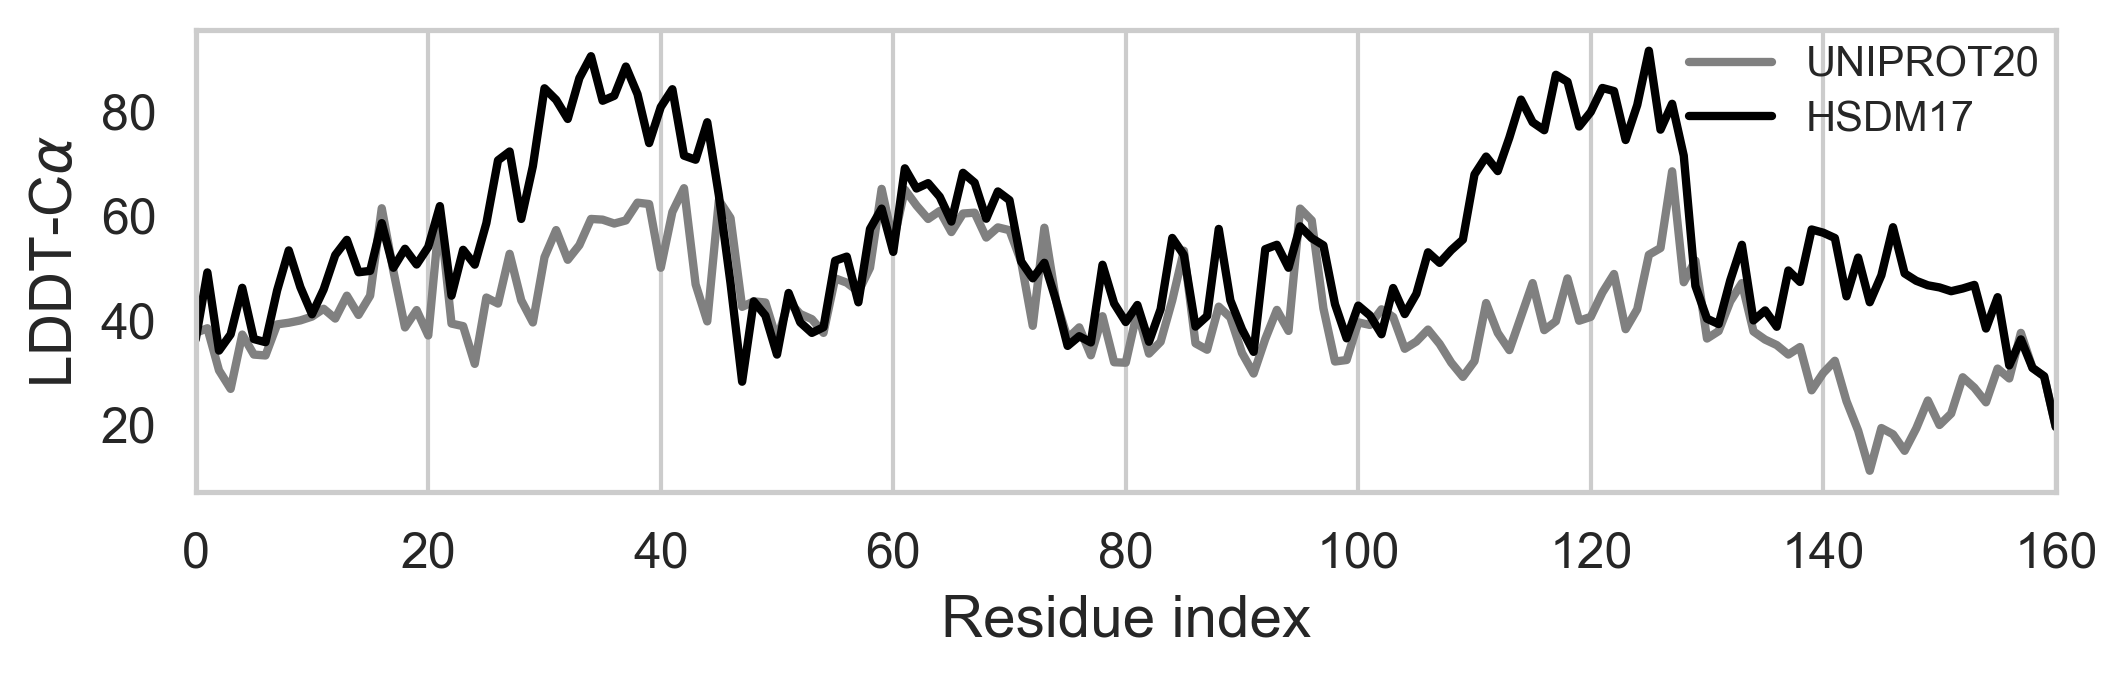

In [334]:
f, ax = plt.subplots(1, 1, figsize=(8, 2), dpi=300)

ax.plot(lddt_uniprot[2], label=r"UNIPROT20", linewidth=2, color='grey')
ax.plot(lddt_alph[2], label= r"HSDM17", linewidth=2, color='black')

plt.legend(borderaxespad=0., fontsize=10,labelspacing=0.4,frameon=False, loc="upper right",
           bbox_to_anchor=(1, 1))

plt.ylabel(r"LDDT-C$\alpha$", size=14)
plt.xlabel("Residue index", size=14)

plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

ax.margins(x=0)
ax.yaxis.grid(False)

plt.subplots_adjust(hspace=0.05)

plt.savefig(f'results/lddt-residue-level-T1039.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/lddt-residue-level-T1039.svg', bbox_inches='tight', dpi=300)

## Plot perplexity

In [9]:
model = load_model(root, version)

In [549]:
def get_pseudo_perplexity(seq, esm_model):
    alphabet = model.esm.alphabet
    data = [("protein1", seq)]
    
    loss = nn.CrossEntropyLoss()
    
    batch_converter = alphabet.get_batch_converter()
    batch_labels, batch_strs, batch_tokens = batch_converter(data)
    
    log_probs = []
    cross_entropies = []
    for i in range(1, len(seq) - 1):
        # masking the position at each i
        batch_tokens_masked = batch_tokens.clone()
        batch_tokens_masked[0, i] = alphabet.mask_idx
        with torch.no_grad():
            token_probs = torch.log_softmax(model.esm(batch_tokens_masked.cuda())["logits"], dim=-1)
            log_probs.append(token_probs[0, i, alphabet.get_idx(seq[i])].item()) 
            
            #cross_entropies.append(loss(model.esm(batch_tokens_masked.cuda())["logits"].cpu().float()[0,i,:], 
             #         torch.tensor(alphabet.get_idx(seq[i])).long()))
            
    return np.exp(-np.mean(log_probs))#, np.exp(-np.mean(cross_entropies))

In [ ]:
with open('seq-pseudo-perplexities.txt', 'w') as log_file:
    for prot_id, seq, alphabet_name, select in tqdm.tqdm(df[['ids', 'seq', 'alphabet_name', 'select']].values):
    
        if prot_id == "T1044":
            continue

        name = f'{prot_id}_{alphabet_name}_{select}'
        
        model.set_chunk_size(1024 if len(seq) <= 500 else 512)
        perplexity = get_pseudo_perplexity(seq, model.esm)
        pppls.append(perplexity)
        
        log_file.write(f"{name}--{perplexity}\n")
        log_file.flush()

In [29]:
df_pp = pd.read_csv('results/txt-files/seq-pseudo-perplexities.txt', delimiter='--', names=['name', 'pppl'])
df_pp

/var/folders/0t/xsc02g1j6z79zd6mkph9lh980000gp/T/ipykernel_31875/4119972736.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_pp = pd.read_csv('results/txt-files/seq-pseudo-perplexities.txt', delimiter='--', names=['name', 'pppl'])


,name,pppl
0,T1024_uniprot21_first,72.517140
1,T1024_uniprot21_reduced_2_first,36.621865
2,T1024_sdm12_first,29.682884
3,T1024_gbmr4_first,3.600334
4,T1024_gbmr7_first,3.992695
...,...,...
445,T1099_gbmr7_first,3.588381
446,T1099_hsdm17_first,14.568548
447,T1099_wass_275_level_1_30bins_first,11.332825
448,T1099_mmseqs2_first,12.152639


In [30]:
impr_targets = {'T1033':['mmseqs2', 'uniprot21_reduced_2', 'gbmr4', 'uniprot21'], 
                'T1035':['gbmr4', 'sdm12', 'gbmr7', 'uniprot21'], 
                "T1039":['hsdm17', 'sdm12', 'gbmr7', 'gbmr4', 'uniprot21'],
                "T1040": ['gbmr7', 'uniprot21'],
                "T1042": ['mmseqs2', 'uniprot21'],
                "T1043": ['uniprot21_reduced_2', 'uniprot21'],
                "T1073": ['uniprot21_reduced_2', 'gbmr7', 'gbmr4', 'uniprot21'],
                "T1074": ['hsdm17', 'sdm12', 'uniprot21'],
                "T1080": ['uniprot21_reduced_2', 'uniprot21'],
                "T1099": ['hsdm17', 'uniprot21']}
impr_targets = [f'{k}_{alph}_first' for k,v in impr_targets.items() for alph in v]

In [ ]:
"""mask = df_pp['name'].apply(lambda x: any(target in x for target in impr_targets))
df_pp = df_pp[mask]"""

In [38]:
df = df[df['ids'] != "T1044"]
df['pppl'] = list(df_pp['pppl'])

uniprot21_pppl = df[df['alphabet_name'] == 'uniprot21'].set_index('ids')['pppl'].to_dict()
df['pppl-diff'] = df.apply(lambda row: uniprot21_pppl.get(row['ids'], 0) - row['pppl'], axis=1)

In [409]:
mask = df.groupby('ids')['pppl-diff'].transform(lambda x: (x > 320).any())
df = df[~mask]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


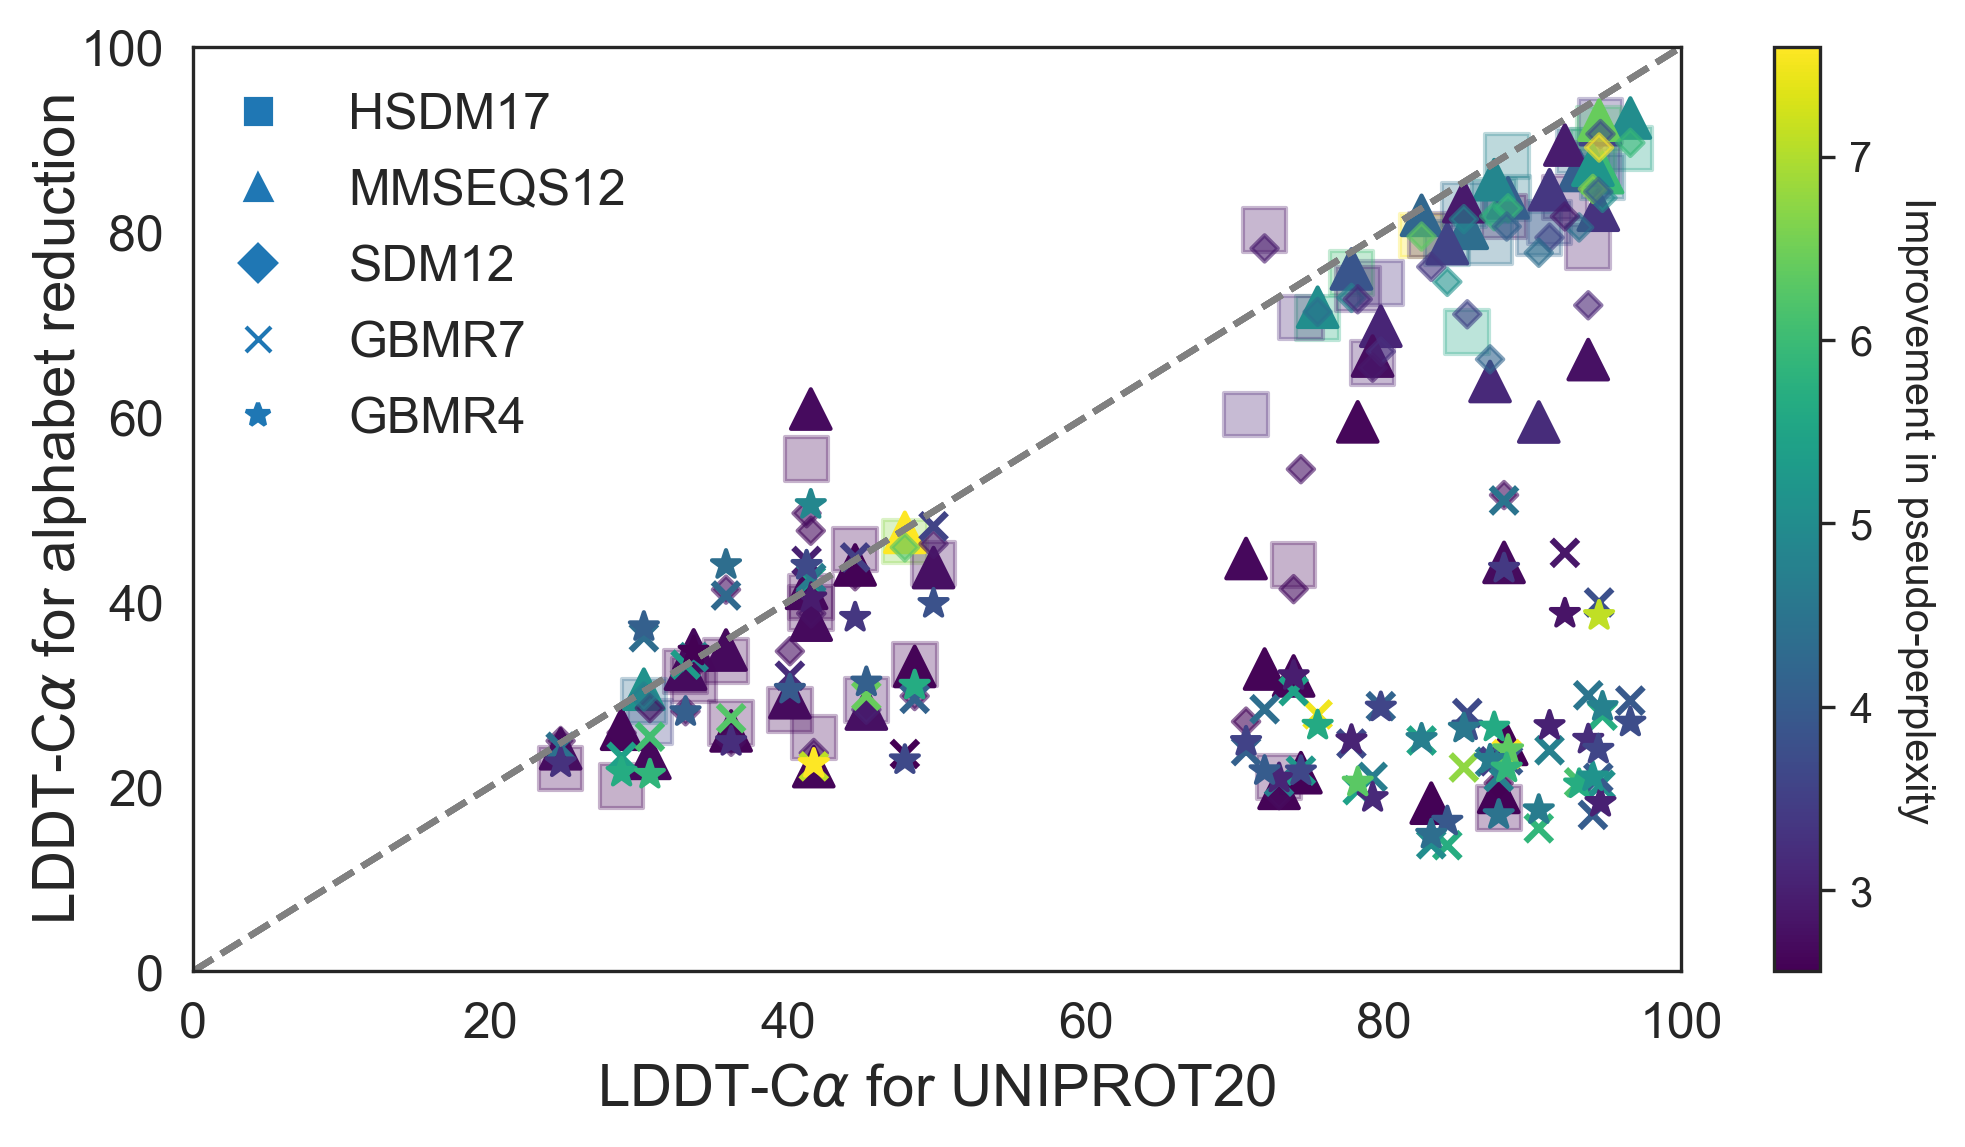

In [39]:
metric = 'LDDT'
label = R'LDDT-C$\alpha$'
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.set_style(style='white')

markers = dict(zip(alph_names_plot[1:], ['o', 's', '^', 'v', 'D', 'x', '+', '*']))
sizes = dict(zip(alph_names_plot[1:], [10, 110, 90, 40, 20, 40, 50, 50]))
alphas = dict(zip(alph_names_plot[1:], [1, 0.3, 1, 0.4, 0.6, 1,1,1]))
colors = {k:v for k,v in zip(alph_names_plot, pal)}

elements = []
for (name, plot_alph_name) in zip(alph_names, alph_names_plot):
    
    if plot_alph_name not in ['HSDM17', 'MMSEQS12', 'GBMR7', 'GBMR4', 'SDM12']:
        continue
    
    # Scatter plot for 'uniprot21' and 'wwmj' with 'select' as 'first'
    plt.scatter(df[df['alphabet_name'] == 'uniprot21'][metric], df[df['alphabet_name'] == name][metric],
                marker=markers[plot_alph_name], s=sizes[plot_alph_name], alpha=alphas[plot_alph_name], c = df[df['alphabet_name'] == name]['pppl'],
               cmap='viridis')
    
    plt.plot([0, 100], [0, 100], color='grey', linestyle='--')
    plt.xlabel(f'{label} for UNIPROT20', fontsize=14)
    plt.ylabel(f'{label} for alphabet reduction', fontsize=14, labelpad=-2)
    plt.xlim(0, 100)
    plt.ylim(0, 100)
    plt.yticks( fontsize=12)
    plt.xticks( fontsize=12)

    elements.append(Line2D([], [], marker=markers[plot_alph_name], label=plot_alph_name,linestyle='None'))
    
colorbar = plt.colorbar()
colorbar.set_label(r'Improvement in pseudo-perplexity', rotation=270, labelpad=15)

plt.legend(handles=elements, loc='upper left', prop={'size': 12},labelspacing=0.6,frameon=False, title_fontsize=14, bbox_to_anchor=(-0.02, 1))
plt.savefig(f'results/pppl-casp14-select=first.eps', bbox_inches='tight', dpi=300)
plt.savefig(f'results/pppl-casp14-select=first.pdf', bbox_inches='tight', dpi=300)
    # Show the plot
plt.show()

## Pairwise alignment

In [30]:
from Bio.Align import substitution_matrices
from Bio import pairwise2

def get_identity_and_similarity(seqa, seqb):
    blosum62 = substitution_matrices.load("BLOSUM62")
    align = pairwise2.align.globalds(seqa, seqb, blosum62, -10, -0.5)
    alignment = align[0]
    aligned_seq1 = alignment.seqA
    aligned_seq2 = alignment.seqB
    
    # Calculate identity and similarity
    identity_count = sum(1 for a, b in zip(aligned_seq1, aligned_seq2) if a == b)
    identity_percentage = (identity_count / len(aligned_seq1)) * 100
    
    similarity_count = sum(1 for a, b in zip(aligned_seq1, aligned_seq2) if blosum62.get((a, b), blosum62.get((b, a))) > 0)
    similarity_percentage = (similarity_count / len(aligned_seq1)) * 100
    
    return identity_percentage, similarity_percentage

In [31]:
identities, similarities = [], []
for prot_id, seq, alphabet_name, select in tqdm.tqdm(df[['ids', 'seq', 'alphabet_name', 'select']].values):
    
    uniprot_seq = df[(df['ids'] == prot_id) & (df['alphabet_name'] == 'uniprot21')]['seq'].iloc[0]
    identity, similarity = get_identity_and_similarity(seq, uniprot_seq)
    
    identities.append(identity)
    similarities.append(similarity)

100%|██████████| 459/459 [00:33<00:00, 13.69it/s]


In [33]:
df['identity'] = identities
df['similarity'] = similarities
df

,Unnamed: 0.3,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,ids,alphabet_name,select,seq,pLDDT,LDDT,identity,similarity
0,0,0,1,1,T1024,uniprot21,first,MKEFWNLDKNLQLRLGIVFLGAFSYGTVFSSMTIYYNQYLGSAITG...,94.079695,79.821074,100.000000,100.000000
1,1,1,3,3,T1024,uniprot21_reduced_2,first,MKEFWNHDKNHQHRHGIVFHGAFSYGTVFSSMTIYYNQYHGSAITG...,80.404882,67.575496,84.068627,84.068627
2,2,2,5,5,T1024,sdm12,first,LKKYWNLDKNLTLKLGLLYLGAYTYGTLYTTLTLYYNTYLGTALTG...,88.405821,67.061913,57.598039,97.303922
3,3,3,7,7,T1024,gbmr4,first,YAAYYAYAAAYAYAYGYYYYGAYAYGAYYAAYAYYYAAYYGAAYAG...,37.073697,28.559595,22.303922,38.480392
4,4,4,9,9,T1024,gbmr7,first,AAAAADADADAAAAAGAAAAGAASAGTAASSATAAADAAAGSAATG...,42.432346,28.677931,34.803922,39.705882
...,...,...,...,...,...,...,...,...,...,...,...,...
454,454,454,909,909,T1099,gbmr7,first,ADADASAAAADAADAPDDAAPAADDAAADAADAAAPAAASDSAAAC...,51.856821,44.774851,40.076336,41.984733
455,455,455,911,911,T1099,hsdm17,first,MDLNASRALANLYDLPDDFFPKLDDLLRDAKDALKPYWKSDSLKKH...,53.126242,45.631549,82.442748,100.000000
456,456,456,913,913,T1099,wass_275_level_1_30bins,first,WDDNASRALANAYDLPDDFFPKDDDLARDAKDALRPYWKSDSDKKS...,43.315601,37.234494,74.427481,74.427481
457,457,457,915,915,T1099,mmseqs2,first,LNINAAKALANIFNLPNNFFPKINNLIKNAKNALEPFWKANAIKKH...,39.170143,43.960634,57.251908,92.748092


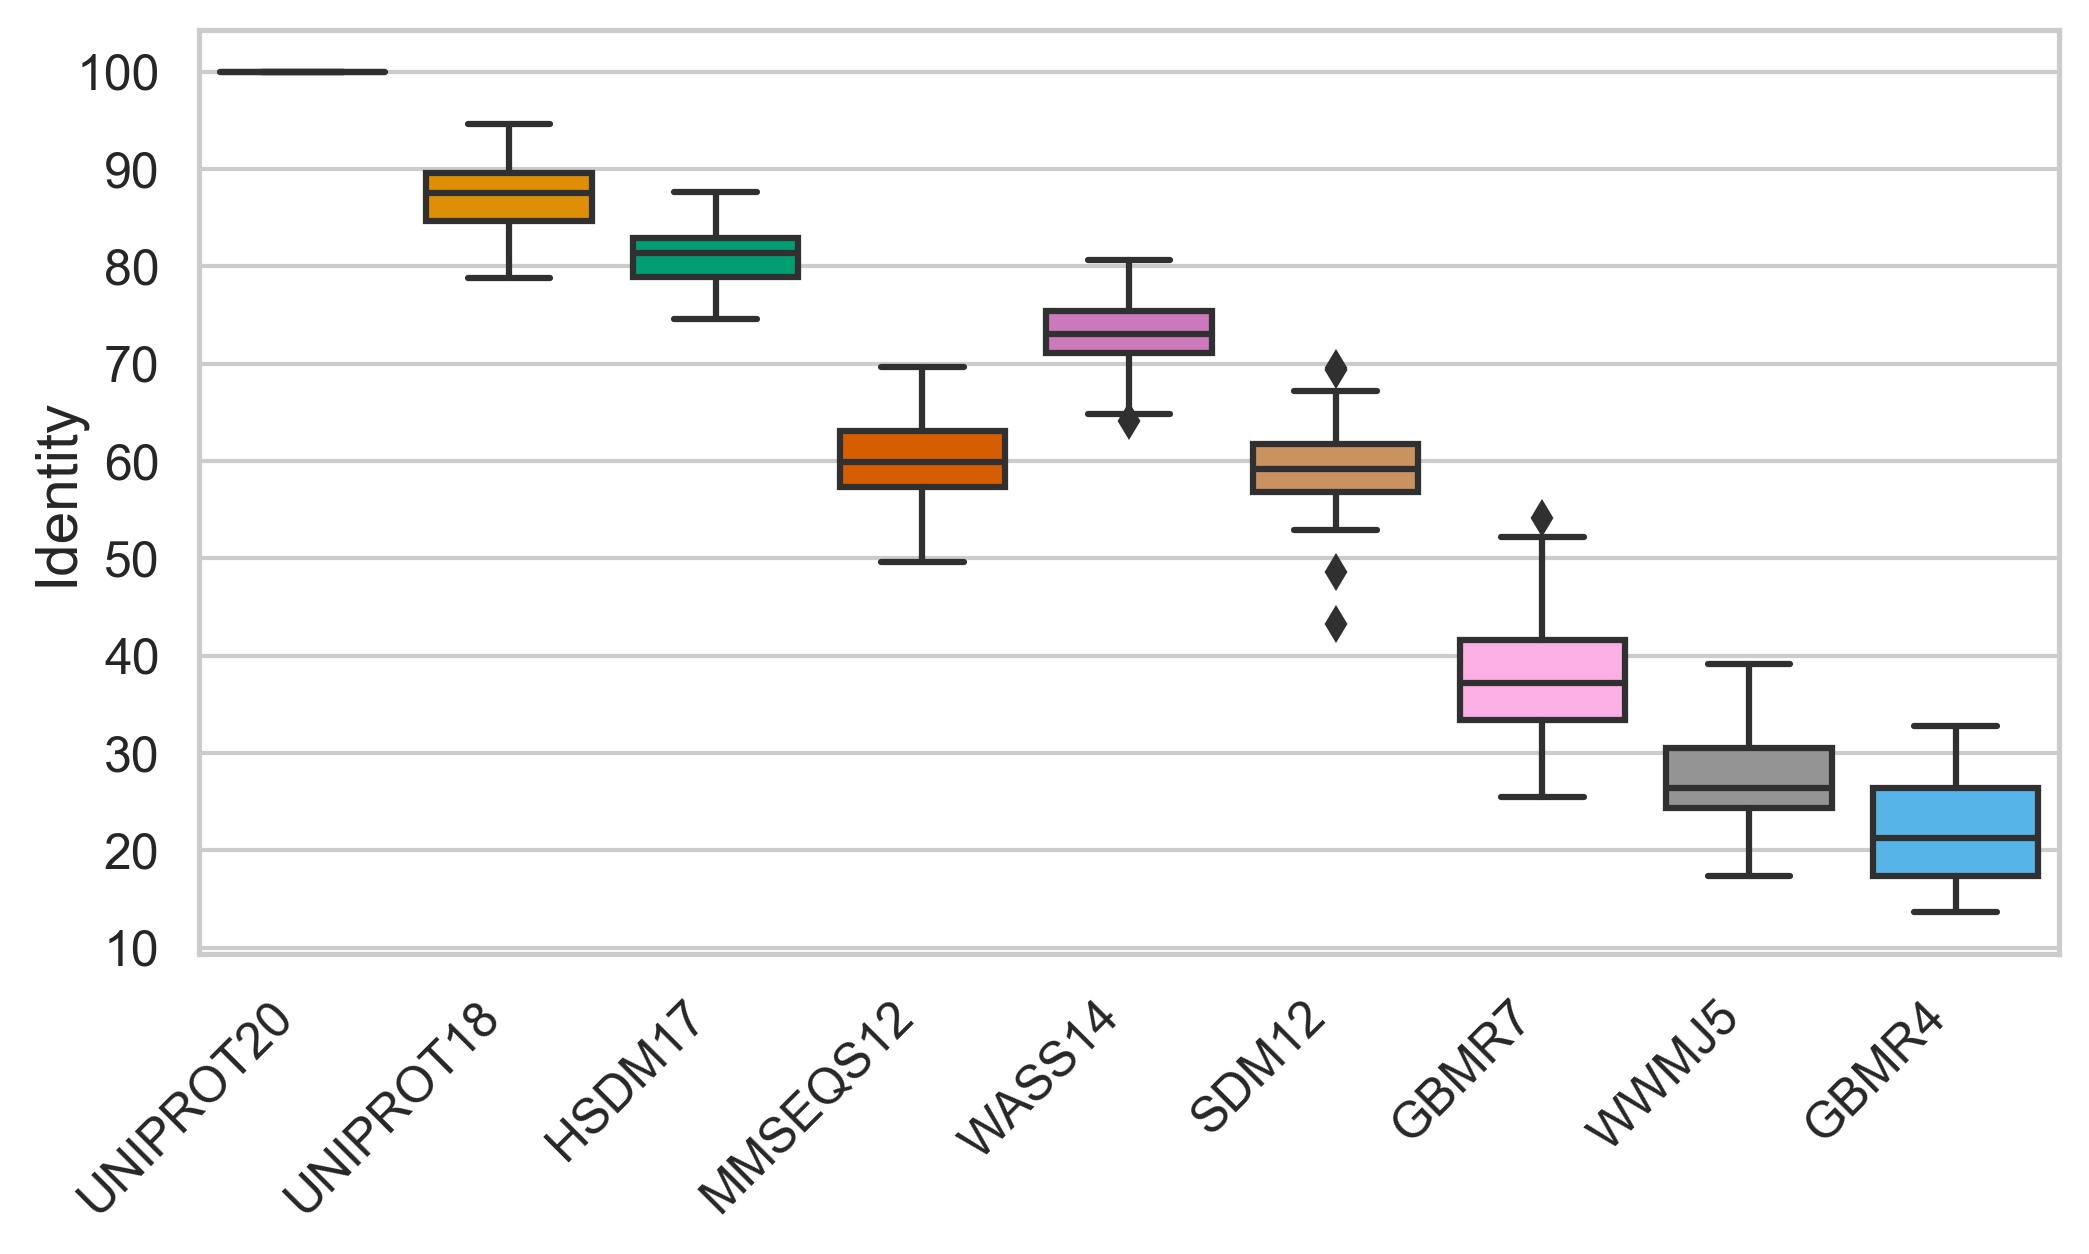

In [34]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.boxplot(x='alphabet_name', y="identity", data=df ,showfliers=True, ax=ax, order=alph_names,
            palette=pal, saturation=1)

ax.set_xticklabels(alph_names_plot, rotation=45, ha='right', fontsize=12)
plt.yticks( fontsize=12);
ax.set_yticks(np.arange(10, 101, 10))
plt.ylabel(r'Identity', fontsize=14, labelpad=-2)
plt.xlabel("")

plt.savefig(f'results/identity-CASP14-alphabets-select-aa-from-cluster={select}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/identity-CASP14-alphabets-select-aa-from-cluster={select}.eps', bbox_inches='tight', dpi=300)

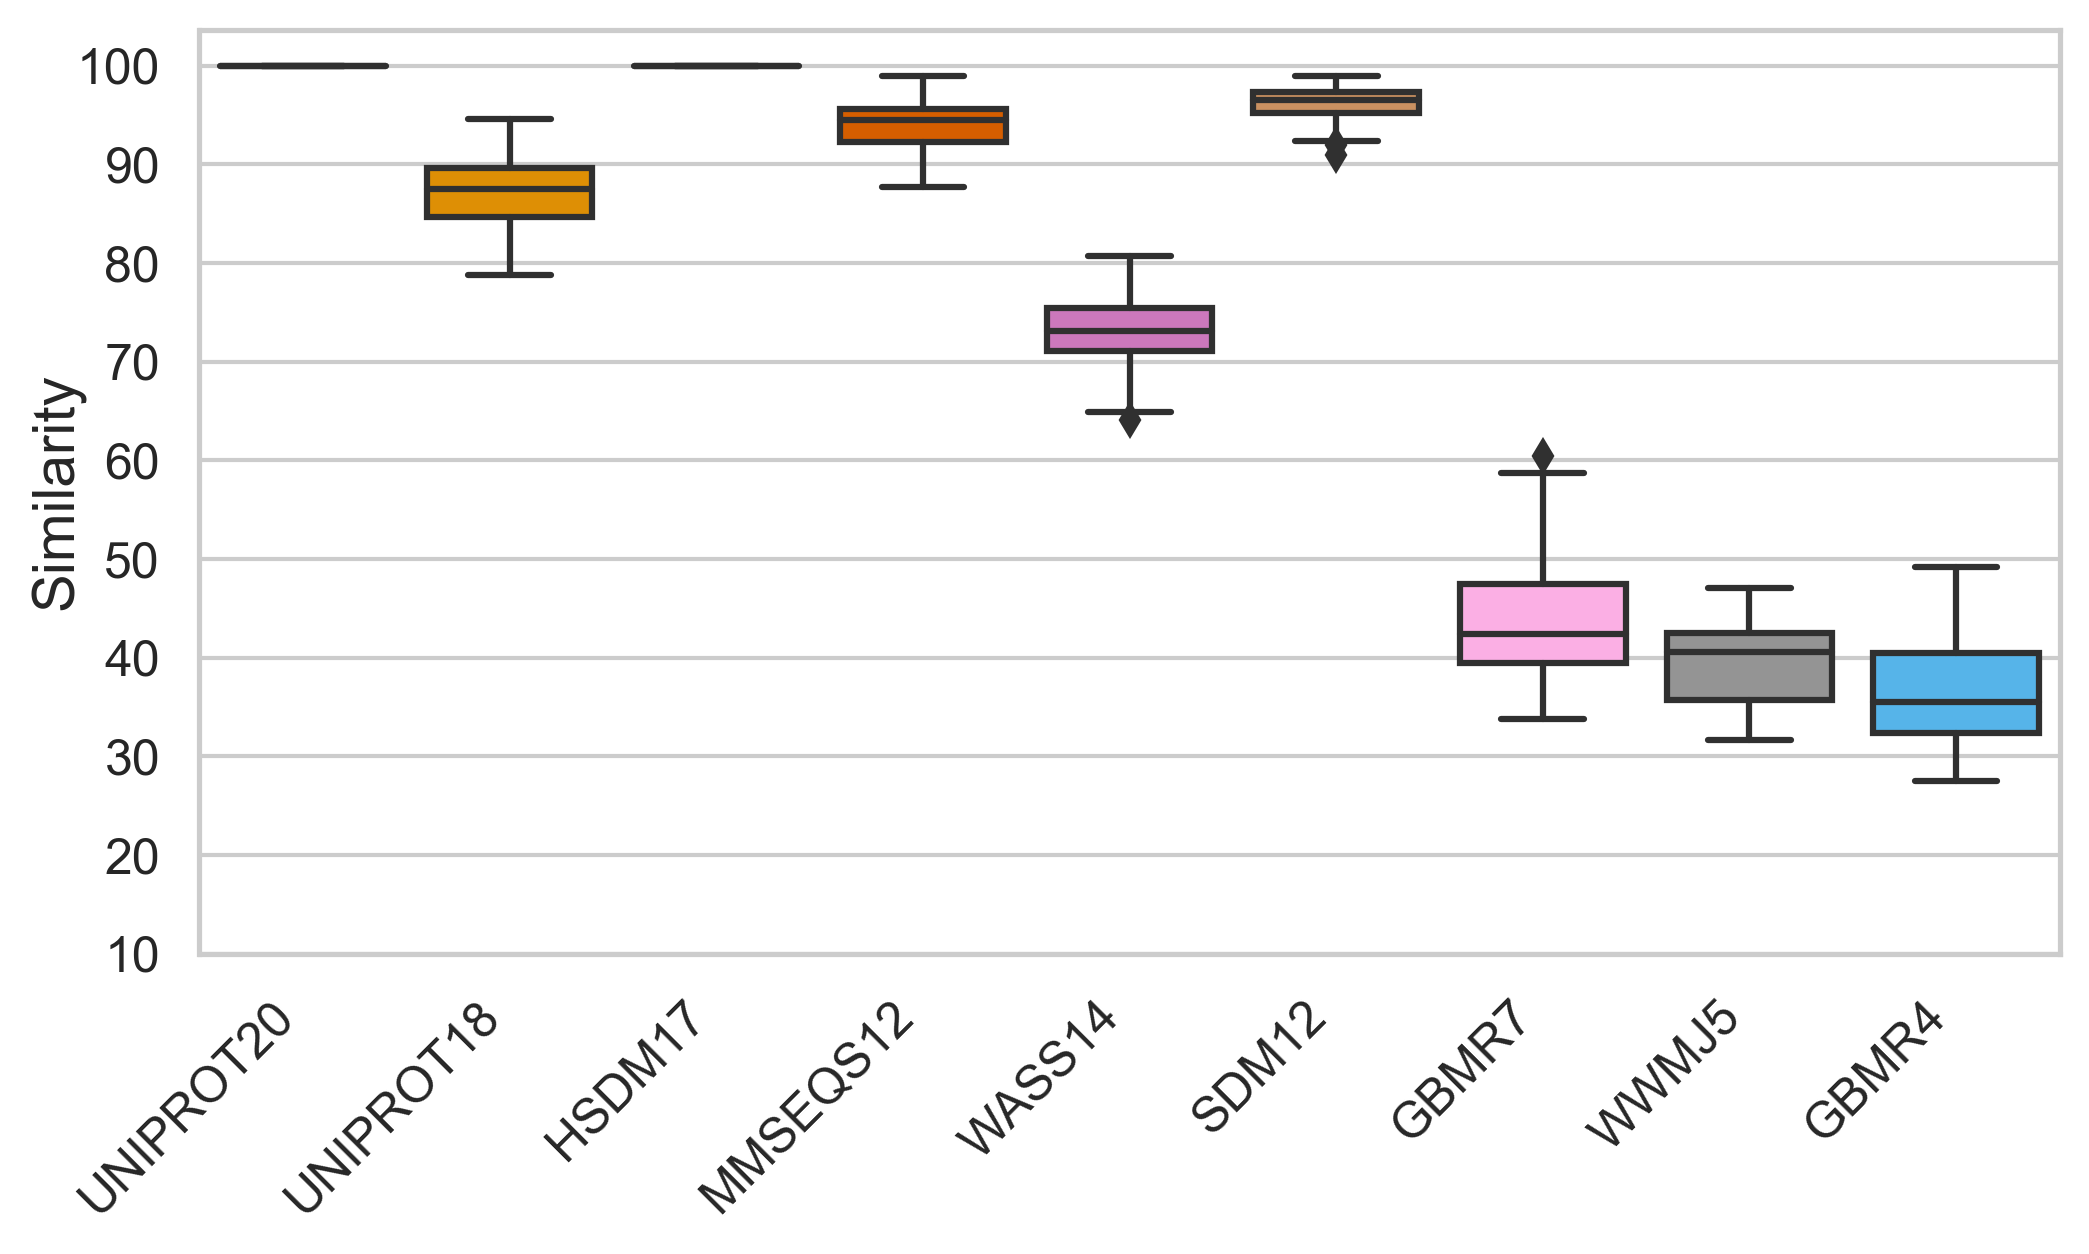

In [37]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(8, 4), dpi=300)

sns.boxplot(x='alphabet_name', y="similarity", data=df ,showfliers=True, ax=ax, order=alph_names,
            palette=pal, saturation=1)

ax.set_xticklabels(alph_names_plot, rotation=45, ha='right', fontsize=12)
plt.yticks( fontsize=12);
ax.set_yticks(np.arange(10, 101, 10))
plt.ylabel(r'Similarity', fontsize=14, labelpad=-2)
plt.xlabel("")

plt.savefig(f'results/similarity-CASP14-alphabets-select-aa-from-cluster={select}.pdf', bbox_inches='tight', dpi=300)
plt.savefig(f'results/similarity-CASP14-alphabets-select-aa-from-cluster={select}.eps', bbox_inches='tight', dpi=300)